In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import signal, stats
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import torch
import torch.nn as nn
from math import floor

path_2 = './part_2'

## Carregar dados

In [157]:
assets = pd.read_csv(path_2 + '/assets.csv')
collects = pd.read_csv(path_2 + '/collects.csv')

In [158]:
assets['sensors'] = assets['sensors'].str[2:-2]
assets = assets.rename(columns={'sensors':'sensorId'})
assets['createdAt'] = pd.to_datetime(assets['createdAt']).dt.tz_localize(None)
assets.head()

_id                   company               createdAt  \
0  602fac7228aba1048d473cc4  5fb2c4eb1369a4325dc4545f 2021-02-19 12:17:54.457   
1  5fd0e297bf7d581c1823b8e4  5fbbadeb82a6b901c26df618 2020-12-09 14:43:35.168   
2  5fb286de1369a4325dc45433  5f6b83e34dd69d4bc799ea1f 2020-11-16 14:04:14.564   
3  6023fad9ed8ef30e9d30952b  5fb2c4eb1369a4325dc4545f 2021-02-10 15:25:13.265   
4  5ff71a150b6abb7be05083b0  5f17203f640a00cc08cb1b3d 2021-01-07 14:26:29.726   

  description                     model      modelType  \
0         NaN  60241102ed8ef30e9d309af9     compressor   
1         NaN  5fd0cf96bf7d581c1823b4c4  heaterFurnace   
2           -  5fb275981369a4325dc4542e    transformer   
3         NaN  6023f7dced8ef30e9d30945f           pump   
4         NaN  5ff5a854adacd8372cf06950           pump   

                                                name sensorId  \
0  Ventilador Acima do Elemento GA160 FF - Prédio...  IAJ9206   
1                                           RDF-61.1  LZY4270   
2                          TRANSFORMADOR 500 KVA N°1  MUR8453   
3      Motor Bomba - Tanque de Expansão Tubo Verde    MXK6435   
4                               CAG1- BAGS.12- Motor  MYD8706   

  specifications.axisX specifications.axisY specifications.axisZ  \
0             vertical           horizontal                axial   
1                axial             vertical           horizontal   
2           horizontal             vertical                  NaN   
3           horizontal                axial             vertical   
4           horizontal                axial             vertical   

   specifications.maxDowntime  specifications.maxTemp  specifications.power  \
0                       48.00                     NaN                   3.7   
1                        0.25                    55.0                   0.0   
2                         NaN                    65.0                   NaN   
3                       48.00                     NaN                   7.0   
4                         NaN                     NaN                  30.0   

   specifications.rpm specifications.workdays  
0              1735.0                     NaN  
1              1740.0                     NaN  
2                 NaN                     NaN  
3              3525.0                     NaN  
4              1765.0                     NaN

In [159]:
assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   _id                         10 non-null     object        
 1   company                     10 non-null     object        
 2   createdAt                   10 non-null     datetime64[ns]
 3   description                 3 non-null      object        
 4   model                       10 non-null     object        
 5   modelType                   10 non-null     object        
 6   name                        10 non-null     object        
 7   sensorId                    10 non-null     object        
 8   specifications.axisX        8 non-null      object        
 9   specifications.axisY        8 non-null      object        
 10  specifications.axisZ        7 non-null      object        
 11  specifications.maxDowntime  6 non-null      float64       
 1

In [160]:
collects = collects.rename(columns={'createdAt':'created'})
collects = collects.drop_duplicates('_id')
collects['created'] = pd.to_datetime(collects['created']).dt.tz_localize(None)
collects.head()

_id                 created  params.accelRMS.x  \
0  60b57955f77013684c413e39 2021-06-01 00:03:33.370           0.010463   
1  60b57c53f77013684c41409f 2021-06-01 00:16:19.173           0.011437   
2  60b57f34f77013684c4142cd 2021-06-01 00:28:36.553           0.010494   
3  60b58237f77013684c41450c 2021-06-01 00:41:27.622           0.009859   
4  60b58515f77013684c414765 2021-06-01 00:53:41.450           0.010014   

   params.accelRMS.y  params.accelRMS.z  params.duration  params.sampRate  \
0           0.004463           0.011677            3.006      1656.686627   
1           0.004983           0.011482            3.006      1656.686627   
2           0.005024           0.011120            3.006      1656.686627   
3           0.004786           0.011096            3.006      1656.686627   
4           0.005213           0.011332            3.006      1656.686627   

   params.timeStart  params.velRMS.x  params.velRMS.y  params.velRMS.z  \
0      1.622506e+09         0.000511         0.000176         0.000289   
1      1.622507e+09         0.000633         0.000238         0.000292   
2      1.622507e+09         0.000524         0.000226         0.000246   
3      1.622508e+09         0.000437         0.000220         0.000248   
4      1.622509e+09         0.000501         0.000251         0.000275   

  sensorId   temp  
0  IAJ9206  23.94  
1  IAJ9206  23.19  
2  IAJ9206  22.50  
3  IAJ9206  22.87  
4  IAJ9206  22.56

In [161]:
collects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33901 entries, 0 to 33900
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                33901 non-null  object        
 1   created            33901 non-null  datetime64[ns]
 2   params.accelRMS.x  33441 non-null  float64       
 3   params.accelRMS.y  33441 non-null  float64       
 4   params.accelRMS.z  33441 non-null  float64       
 5   params.duration    33441 non-null  float64       
 6   params.sampRate    33441 non-null  float64       
 7   params.timeStart   33441 non-null  float64       
 8   params.velRMS.x    33441 non-null  float64       
 9   params.velRMS.y    33441 non-null  float64       
 10  params.velRMS.z    33441 non-null  float64       
 11  sensorId           33901 non-null  object        
 12  temp               33901 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 3.

In [162]:
print(assets['sensorId'].unique())
print(collects['sensorId'].unique())

['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']
['IAJ9206' 'LZY4270' 'MUR8453' 'MXK6435' 'MYD8706' 'MYS2071' 'MZU6388'
 'NAH4736' 'NAI1549' 'NEW4797']


In [163]:
# relacionamento entre base de ativos e monitoramento
full_df = collects.merge(assets, how='left', on='sensorId')
full_df.head()

_id_x                 created  params.accelRMS.x  \
0  60b57955f77013684c413e39 2021-06-01 00:03:33.370           0.010463   
1  60b57c53f77013684c41409f 2021-06-01 00:16:19.173           0.011437   
2  60b57f34f77013684c4142cd 2021-06-01 00:28:36.553           0.010494   
3  60b58237f77013684c41450c 2021-06-01 00:41:27.622           0.009859   
4  60b58515f77013684c414765 2021-06-01 00:53:41.450           0.010014   

   params.accelRMS.y  params.accelRMS.z  params.duration  params.sampRate  \
0           0.004463           0.011677            3.006      1656.686627   
1           0.004983           0.011482            3.006      1656.686627   
2           0.005024           0.011120            3.006      1656.686627   
3           0.004786           0.011096            3.006      1656.686627   
4           0.005213           0.011332            3.006      1656.686627   

   params.timeStart  params.velRMS.x  params.velRMS.y  ...   modelType  \
0      1.622506e+09         0.000511         0.000176  ...  compressor   
1      1.622507e+09         0.000633         0.000238  ...  compressor   
2      1.622507e+09         0.000524         0.000226  ...  compressor   
3      1.622508e+09         0.000437         0.000220  ...  compressor   
4      1.622509e+09         0.000501         0.000251  ...  compressor   

                                                name  specifications.axisX  \
0  Ventilador Acima do Elemento GA160 FF - Prédio...              vertical   
1  Ventilador Acima do Elemento GA160 FF - Prédio...              vertical   
2  Ventilador Acima do Elemento GA160 FF - Prédio...              vertical   
3  Ventilador Acima do Elemento GA160 FF - Prédio...              vertical   
4  Ventilador Acima do Elemento GA160 FF - Prédio...              vertical   

  specifications.axisY specifications.axisZ specifications.maxDowntime  \
0           horizontal                axial                       48.0   
1           horizontal                axial                       48.0   
2           horizontal                axial                       48.0   
3           horizontal                axial                       48.0   
4           horizontal                axial                       48.0   

  specifications.maxTemp specifications.power specifications.rpm  \
0                    NaN                  3.7             1735.0   
1                    NaN                  3.7             1735.0   
2                    NaN                  3.7             1735.0   
3                    NaN                  3.7             1735.0   
4                    NaN                  3.7             1735.0   

  specifications.workdays  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 28 columns]

## Creating assets data object

In [164]:
class Asset:
    def __init__(self, df, row):
        self.sensorID = row['sensorId']
        self.company = row['company']
        self.description = row['description']
        self.model = row['model']
        self.modelType = row['modelType']
        self.name = row['name']
        self.axisX = row['specifications.axisX']
        self.axisY = row['specifications.axisY']
        self.axisZ = row['specifications.axisZ']
        self.maxDowntime = row['specifications.maxDowntime']
        self.maxTemp = row['specifications.maxTemp']
        self.power = row['specifications.power']
        self.rpm = row['specifications.rpm']
        self.power = row['specifications.power']
        self.workdays = row['specifications.workdays']
        
        self.df = self.setData(df)

        self.calcDownTime()

    def setData(self, df):
        df = df[df['sensorId'] == self.sensorID].sort_values(by='created')
        df['delta_created'] = df['created'].diff(-1)
        df['delta_created'] = df['delta_created'].dt.total_seconds()*-1
        df['time_s'] = df['created']-df['created'].min()
        df['time_s'] = df['time_s'].dt.total_seconds()
        df['time_s_2'] = df['params.timeStart'] - df['params.timeStart'].min()
        df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z']] = df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z'
            ]].fillna(np.nan)
        df['time_s_3'] = df['time_s_2']
        df['time_s_2'] = df['time_s_2'].fillna(df['time_s'])
        df = df.reset_index(drop=True)

        self.details = '\
        company: {}\n\
        name: {}\n\
        sensorID: {}\n\
        model: {}\n\
        model type: {}\n\
        maxTemp: {}\n\
        power: {}\n\
        rpm: {}'.format(
            self.company,
            self.name,
            self.sensorID,
            self.model,
            self.modelType,
            self.maxTemp,
            self.power,
            self.rpm)
        
        return df
    
    def plotData(self):
        # diagram plots
        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        l1, = axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        l2 = axes[1][0].axhline(y = self.amp_x*0.05 + self.df['params.accelRMS.x'].min(), color = 'r', linestyle = '-')
        axes[1][0].legend([l1, l2], ['acel. signal', 'upper bound downtime'], loc = 'upper right')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[2][0].axhline(y = self.amp_y*0.05 + self.df['params.accelRMS.y'].min(), color = 'r', linestyle = '-')
        axes[3][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[3][0].axhline(y = self.amp_z*0.05 + self.df['params.accelRMS.z'].min(), color = 'r', linestyle = '-')

        axes[1][1].plot(self.df['time_s_2'], self.df['params.velRMS.x'], color='green')
        axes[2][1].plot(self.df['time_s_2'], self.df['params.velRMS.y'], color='green')
        axes[3][1].plot(self.df['time_s_2'], self.df['params.velRMS.z'], color='green')

        axes[0][1].plot(self.df['time_s_2'], self.df['temp'], color = 'orange')

        axes[0][0].text(0.05, 0.95, self.details, fontsize=8, horizontalalignment='left', verticalalignment='top')

        fig.suptitle('Asset - {}'.format(self.name))
        axes[0,0].set_title('details')
        axes[0,1].set_title('temp.')
        axes[1,0].set_title('acel.')
        axes[1,1].set_title('veloc.')
        axes[1,0].set_ylabel('x')
        axes[2,0].set_ylabel('y')
        axes[3,0].set_ylabel('z')
        axes[3,0].set_xlabel('time')
        axes[3,1].set_xlabel('time')

    def calcDownTime(self):
        # calculo e impressão de downtime
        self.amp_x = self.df['params.accelRMS.x'].max() - self.df['params.accelRMS.x'].min()
        self.amp_y = self.df['params.accelRMS.y'].max() - self.df['params.accelRMS.y'].min()
        self.amp_z = self.df['params.accelRMS.z'].max() - self.df['params.accelRMS.z'].min()

        self.df['downtime'] = np.where(
            ((self.df['params.accelRMS.x'].isnull())|
            (self.df['params.accelRMS.y'].isnull())|
            (self.df['params.accelRMS.z'].isnull()))|
            ((self.df['params.accelRMS.x'] < self.amp_x*0.05 + self.df['params.accelRMS.x'].min())|
            (self.df['params.accelRMS.y'] < self.amp_y*0.05 + self.df['params.accelRMS.y'].min())|
            (self.df['params.accelRMS.z'] < self.amp_z*0.05 + self.df['params.accelRMS.z'].min()))|
            (self.df['delta_created'] > self.df['delta_created'].mean()*1.1), True, False)

        down_df = self.df.iloc[:-1] # excluir primeira linha, pois não tem delta
        down_df = down_df[down_df['downtime']]
        self.totalTime = self.df['params.timeStart'].max() - self.df['params.timeStart'].min()
        self.downTime = down_df['delta_created'].sum()
        print('{} - uptime: {:.0f} s, downtime: {:.0f} s - {:.2f}%'.format(
            self.name, self.totalTime-self.downTime, self.downTime, 100*self.downTime/self.totalTime)
        )

    def normalize(self):
        # normalização dos vetores de aceleração [0,1] preservando a proporção
        max_val = max(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].max())
        min_val = min(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].min())
        self.df[
            ['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']
        ] = (self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']]-min_val)/(max_val-min_val)
        
        self.df['params.accelRMS.x_n'] = self.df['params.accelRMS.x_n'].fillna(-1)
        self.df['params.accelRMS.y_n'] = self.df['params.accelRMS.y_n'].fillna(-1)
        self.df['params.accelRMS.z_n'] = self.df['params.accelRMS.z_n'].fillna(-1)

    def varDetection(self):
        # teste utilizando Isolation forest
        self.isForest = IsolationForest(contamination=0.04, max_samples=floor(len(self.df)*0.1))
        pred = self.isForest.fit_predict(self.df[['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']])
        self.df['pred'] = np.where(pred == -1, True, False)
        self.df['params.accelRMS.x_p'] = np.where(self.df['pred'], self.df['params.accelRMS.x'], np.nan)
        self.df['params.accelRMS.y_p'] = np.where(self.df['pred'], self.df['params.accelRMS.y'], np.nan)
        self.df['params.accelRMS.z_p'] = np.where(self.df['pred'], self.df['params.accelRMS.z'], np.nan)

        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x_p'], '-*', color='red')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y_p'], '-*', color='red')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z_p'], '-*', color='red')
        pass


Ventilador Acima do Elemento GA160 FF - Prédio B015 - uptime: 642593 s, downtime: 2471612 s - 79.37%
RDF-61.1 - uptime: 1908978 s, downtime: 1205098 s - 38.70%
TRANSFORMADOR 500 KVA N°1 - uptime: 1687716 s, downtime: 1421396 s - 45.72%
Motor Bomba - Tanque de Expansão Tubo Verde   - uptime: 692344 s, downtime: 2421593 s - 77.77%
CAG1- BAGS.12- Motor - uptime: 1266423 s, downtime: 1847763 s - 59.33%
VTF-61.1 - uptime: 3022002 s, downtime: 92104 s - 2.96%
Boko MA-1510 - Motor 2 da UH - uptime: 372505 s, downtime: 2741936 s - 88.04%
Ventilador -GA75 FF - Prédio B104 - uptime: 1649779 s, downtime: 1434967 s - 46.52%
CAG1- BAGS.3- Motor  - uptime: 1224573 s, downtime: 1889622 s - 60.68%
ROTULADORA SIDEL  - uptime: 1422934 s, downtime: 1691270 s - 54.31%


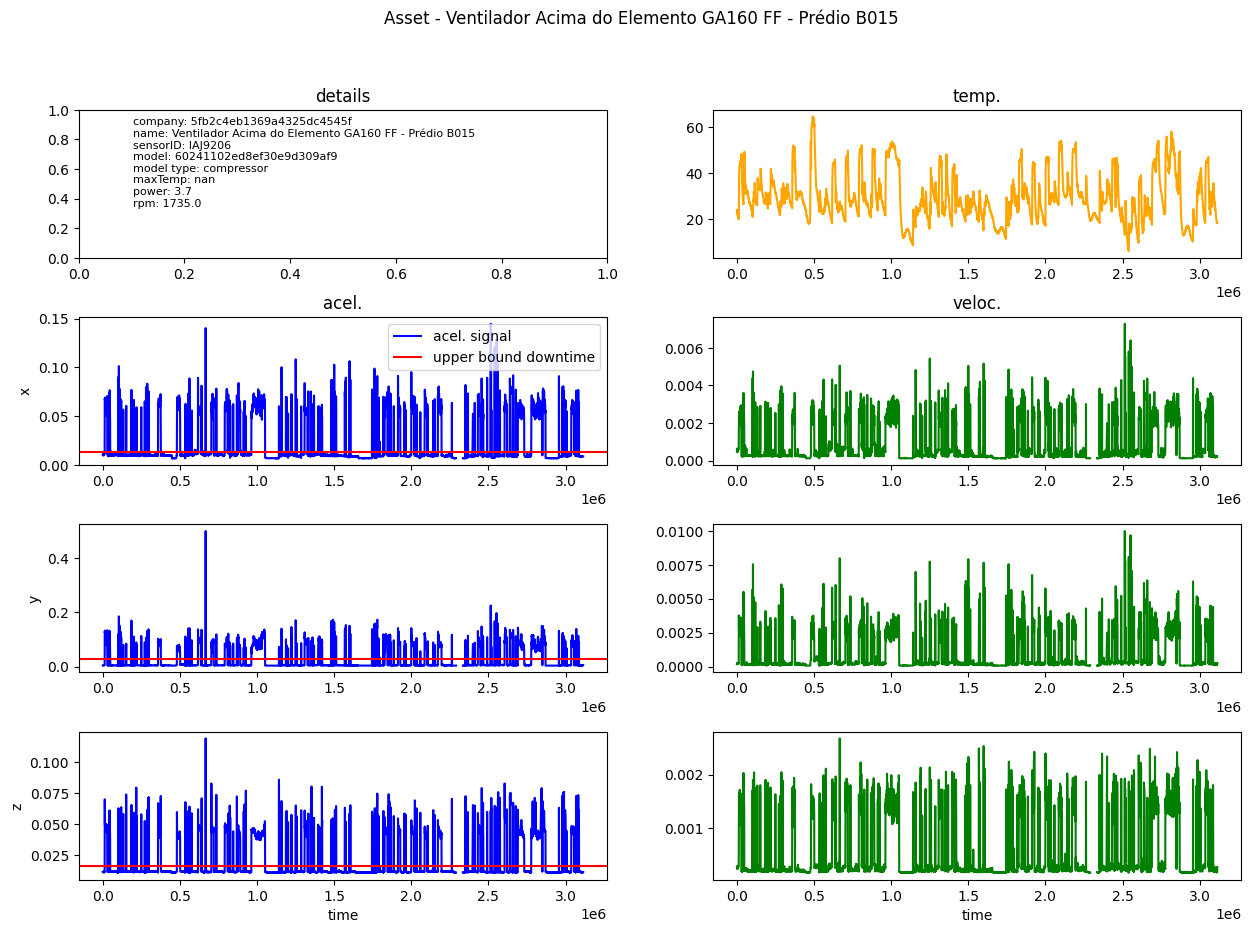

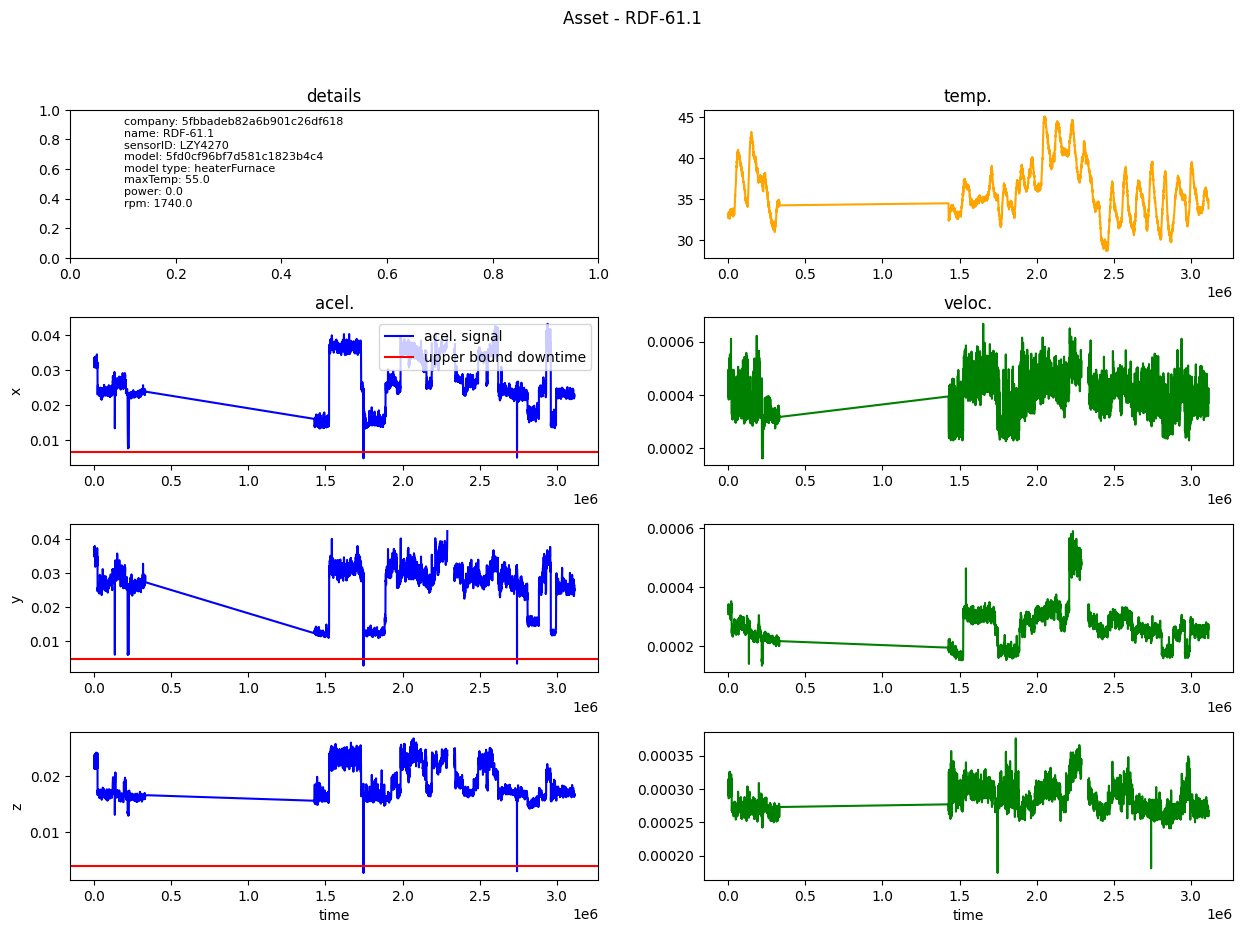

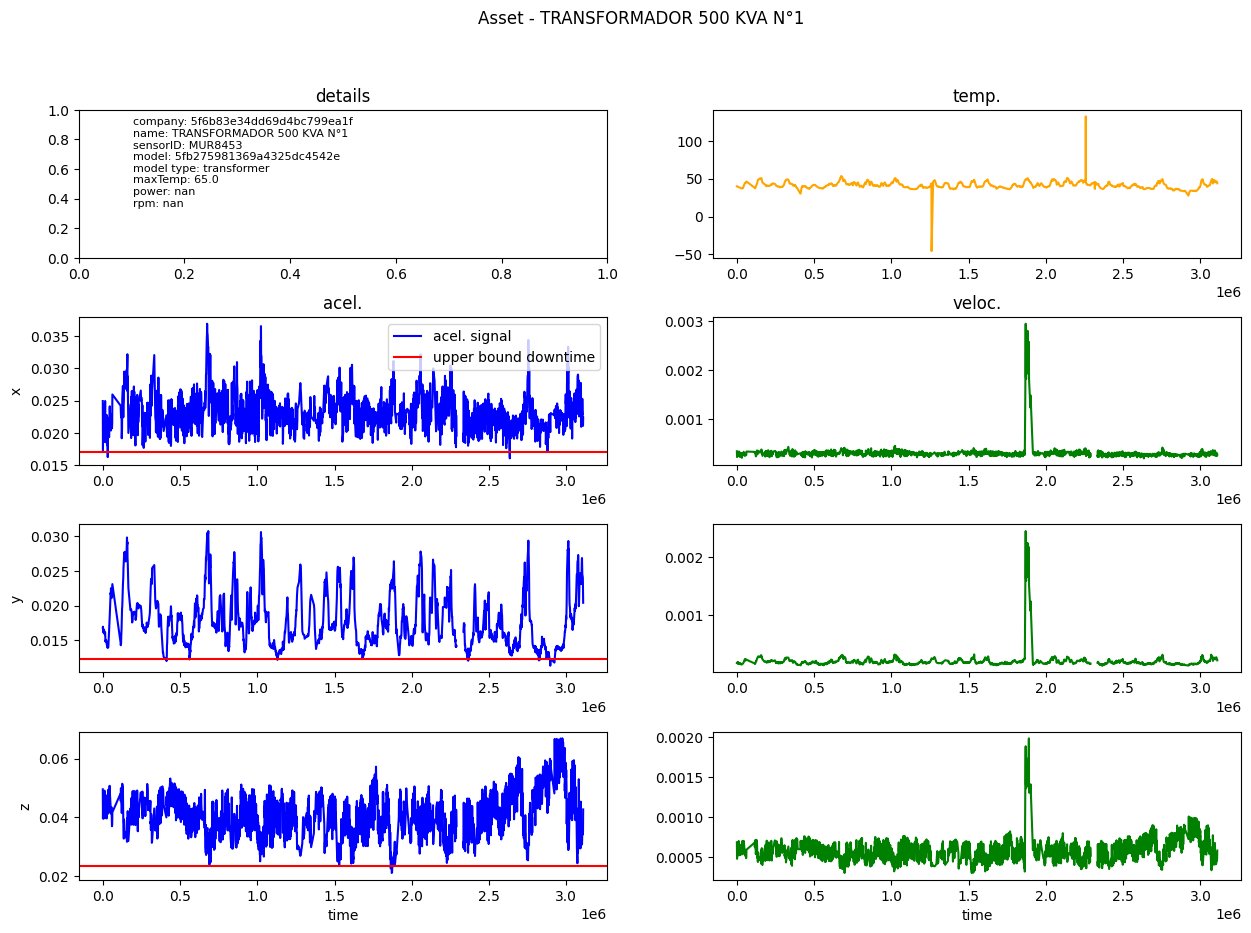

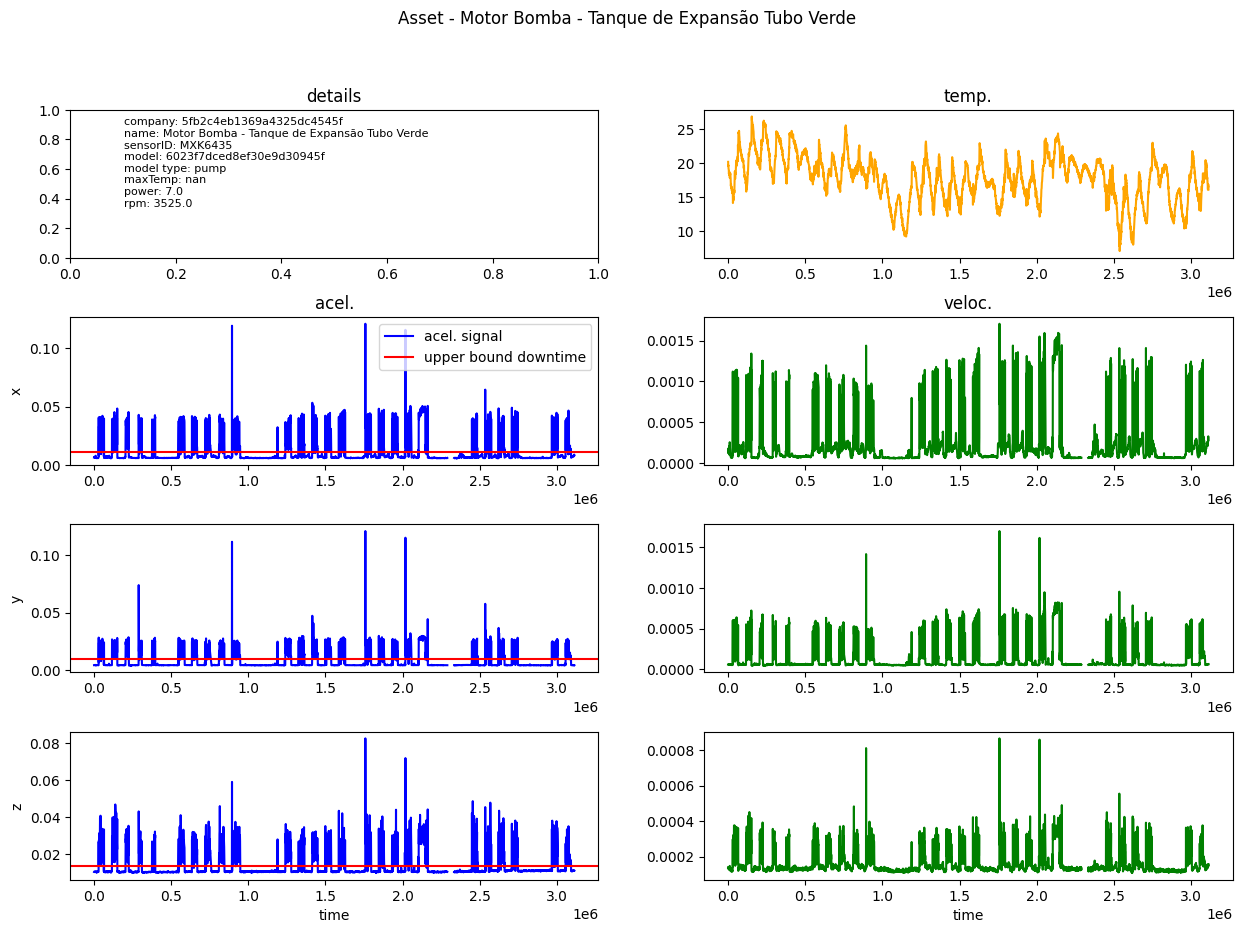

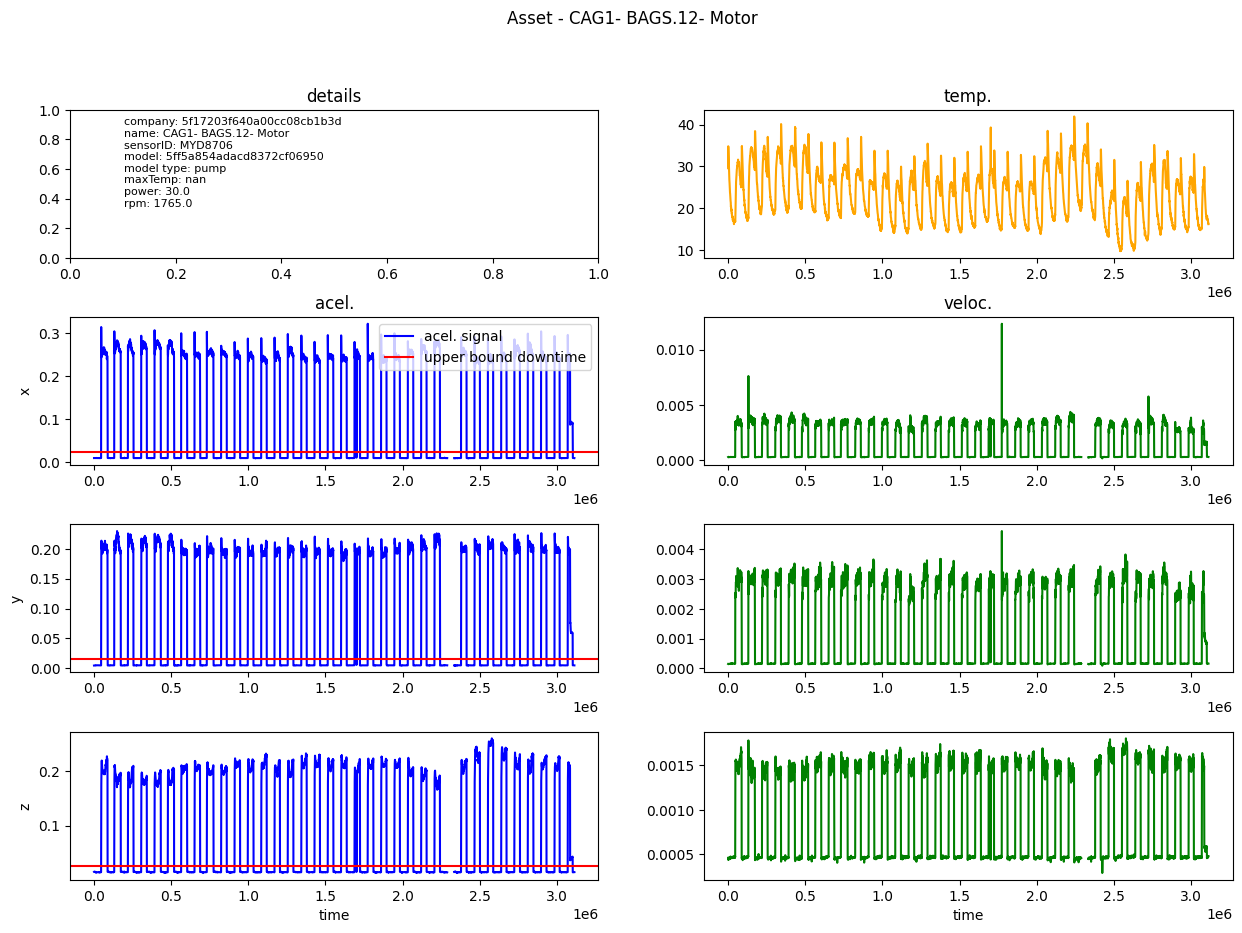

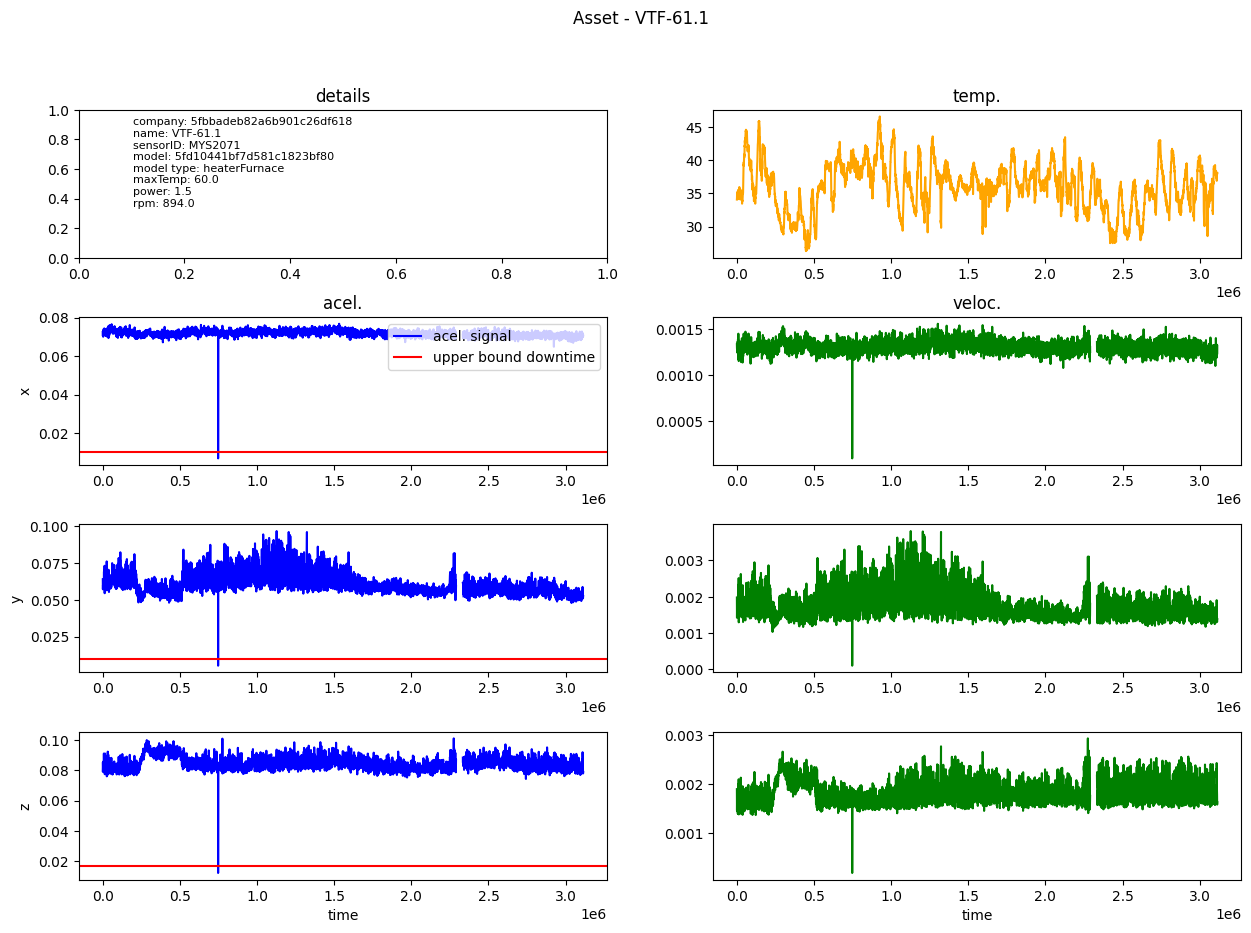

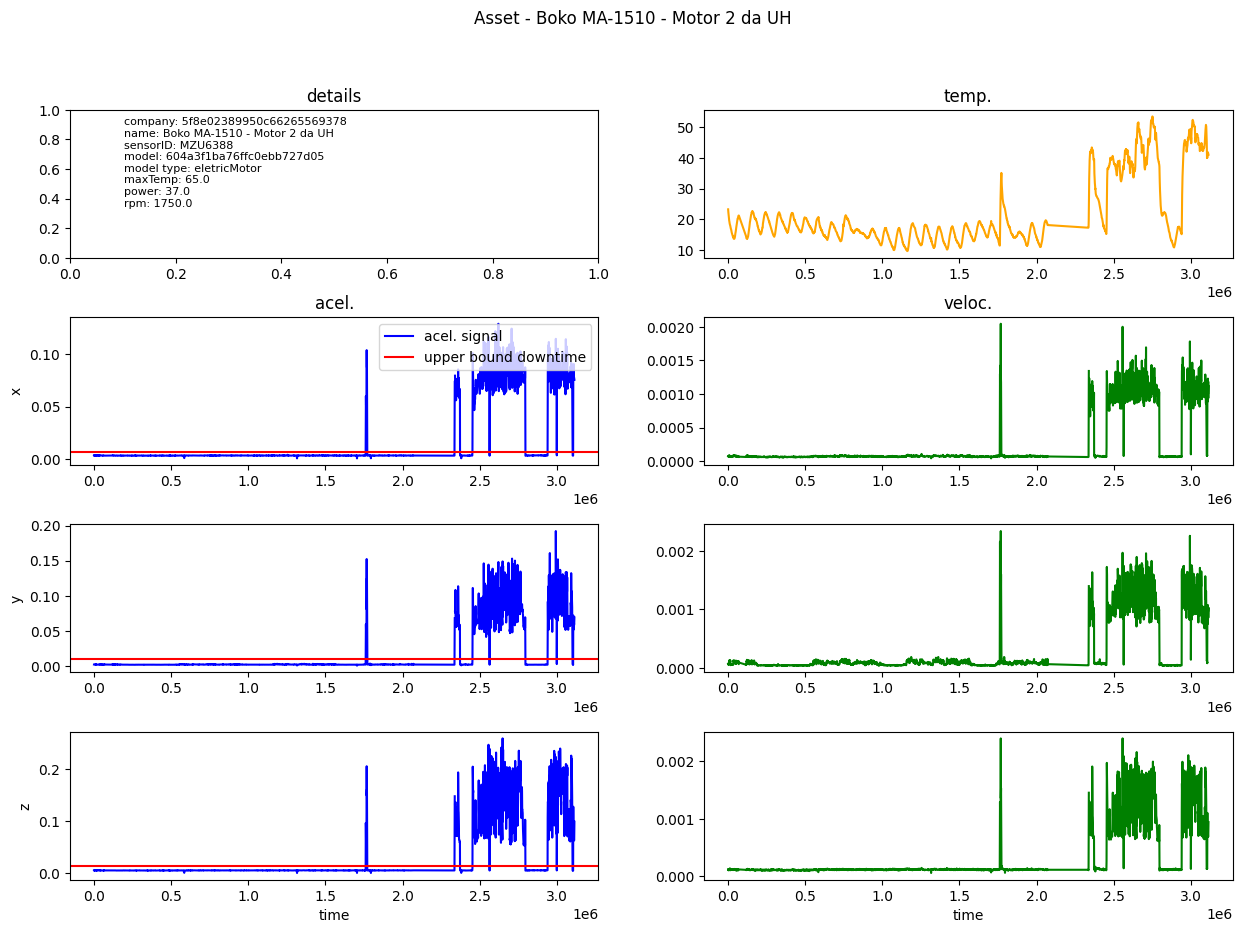

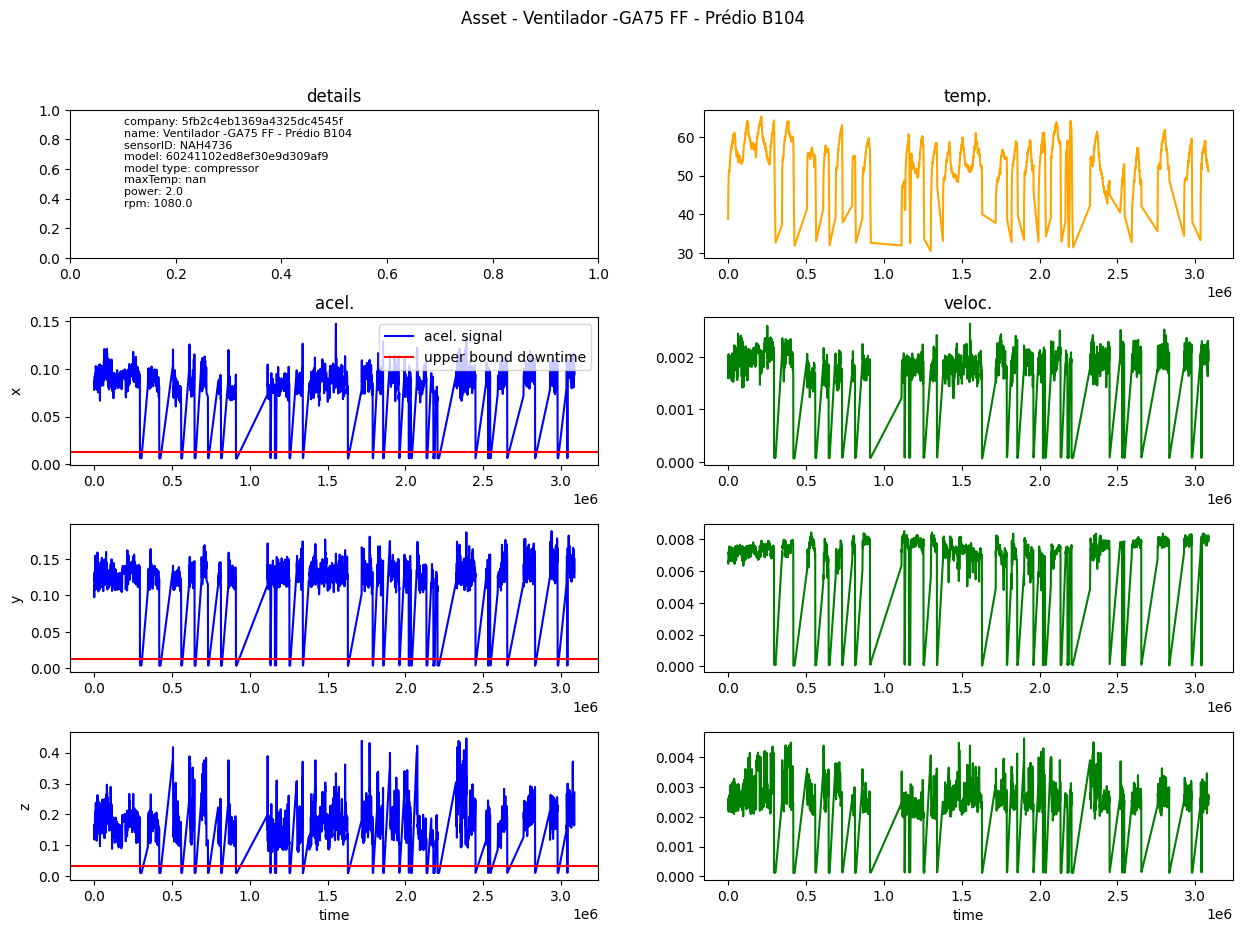

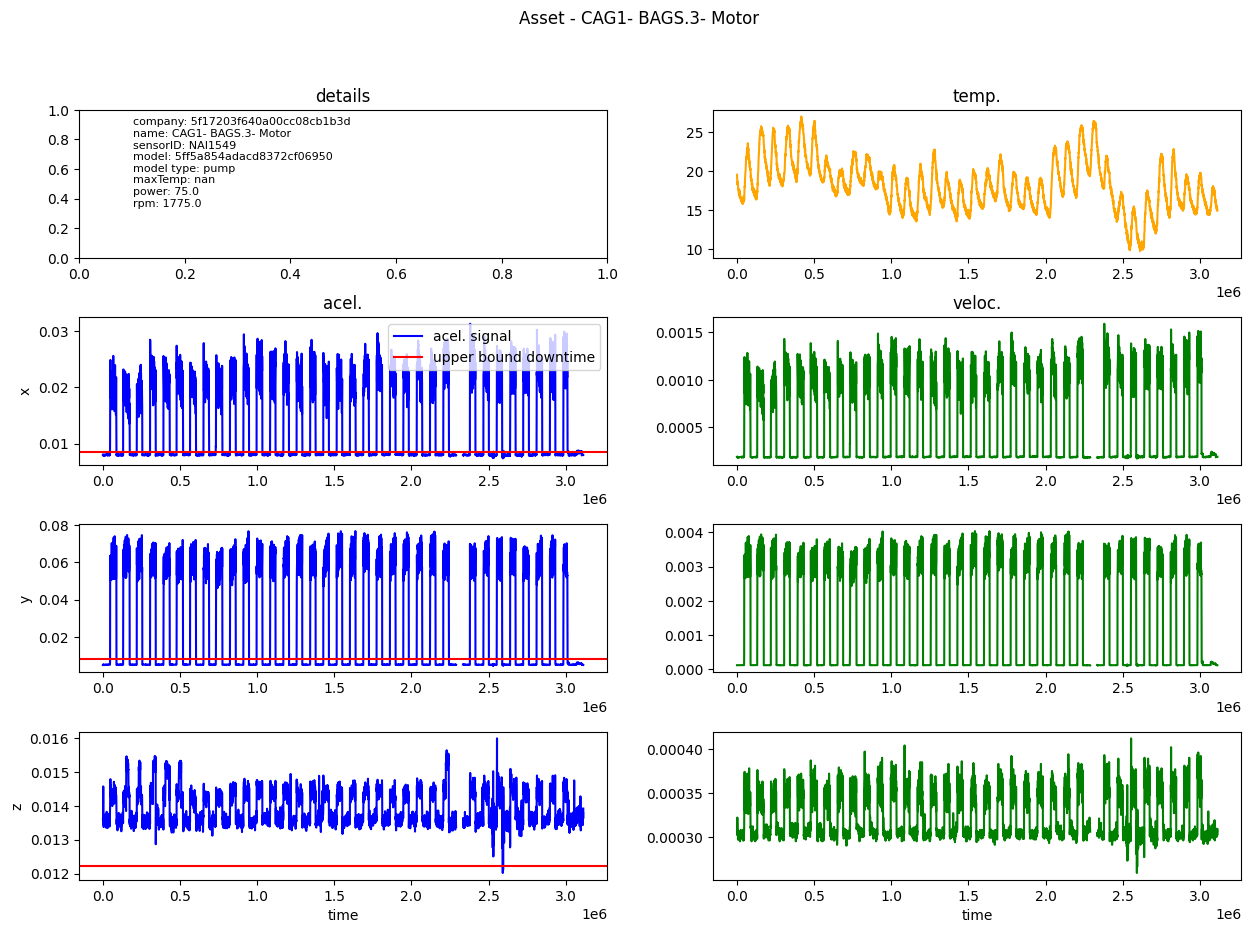

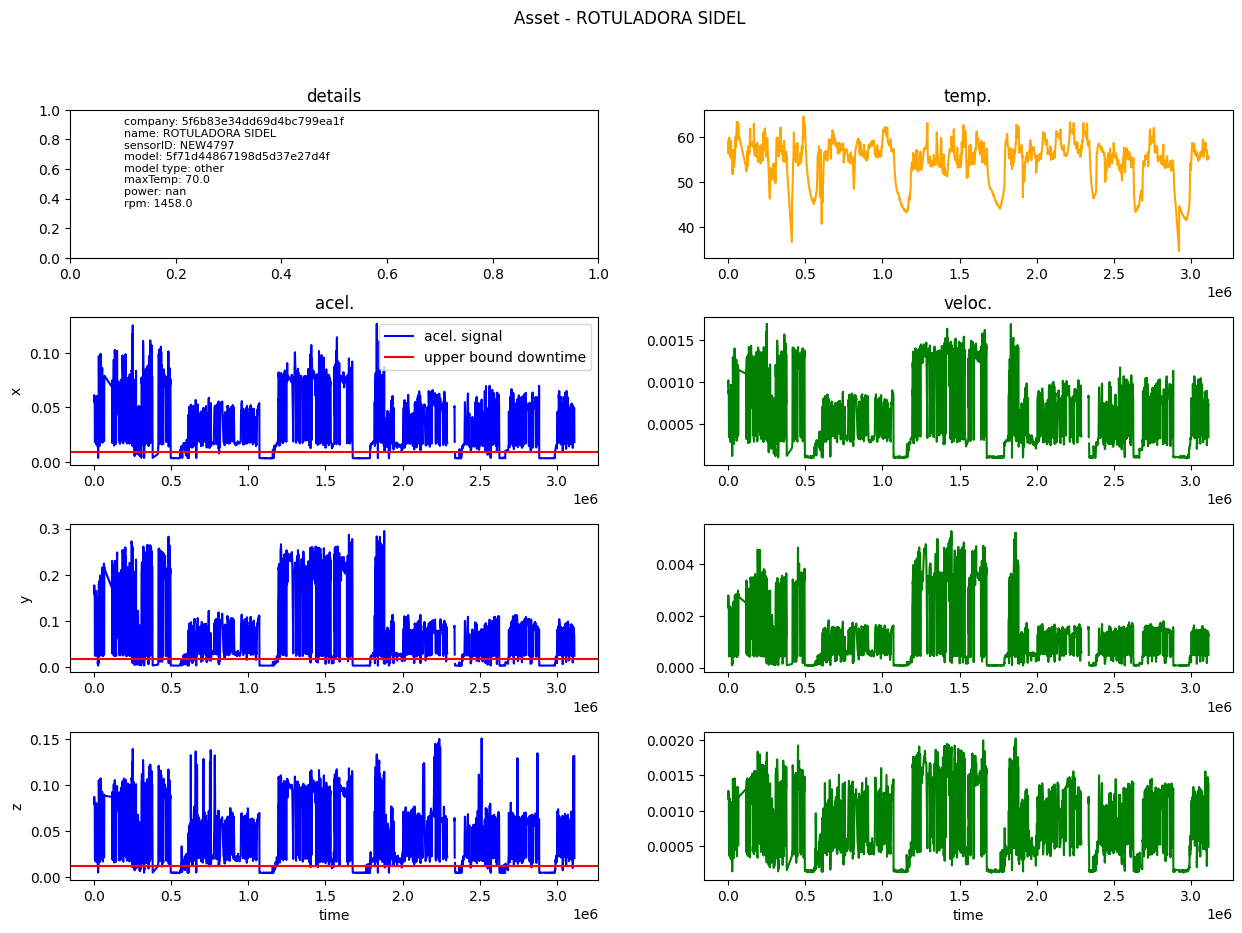

In [165]:
mach = list(assets['sensorId'].unique())
data = {}

# Create asset object and print details
for idx, row in assets.iterrows():
    data[row['sensorId']] = Asset(full_df, row)
    data[row['sensorId']].plotData()
    

## Data normalization for vibration chage detection

In [166]:
for i in data:
    data[i].normalize()
    # data[row['sensorId']].varDetection()

## Neural network for pattern change detection

In [167]:
class Cnn:
    def __init__(self, data):
        # define datasets
        cols = ['params.accelRMS.x_n','params.accelRMS.y_n', 'params.accelRMS.z_n']
        self.name = data.name
        self.df = data.df[cols + ['time_s_2']]
        self.df = self.df.reset_index(drop=True)

        self.windowLen = floor(len(self.df)/20)
        self.step = floor(len(self.df)/25)

        self.xdataSet = [np.array(self.df[cols].iloc[i:i+self.windowLen].values) for i in range(len(self.df) - (self.windowLen))]
        self.ydataSet = [np.array(self.df[cols].iloc[i+self.windowLen].values) for i in range(len(self.df) - (self.windowLen))]

        self.xdataSet = torch.tensor(np.array(self.xdataSet),dtype=torch.float32, requires_grad=True)
        self.ydataSet = torch.tensor(np.array(self.ydataSet),dtype=torch.float32, requires_grad=True)

        self.xdataSet_train = self.xdataSet[
            [i for i in range(0,len(self.xdataSet),self.step) if not ((-1 in self.xdataSet[i]) | (-1 in self.ydataSet[i]))]]
        self.ydataSet_train = self.ydataSet[
            [i for i in range(0,len(self.ydataSet),self.step) if not ((-1 in self.xdataSet[i]) | (-1 in self.ydataSet[i]))]]
        
        self.cnnModel()
        
    def cnnModel(self):
        self.model = nn.Sequential(
            nn.Conv1d(self.windowLen, floor(self.windowLen/2), 3),
            nn.ReLU(),
            nn.Conv1d(floor(self.windowLen/2), floor(self.windowLen/10), 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(floor(self.windowLen/10), floor(self.windowLen/10)),
            nn.Linear(floor(self.windowLen/10), 3)
        )
        # self.loss_fn = nn.CrossEntropyLoss()
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self, epochs):
        for n in range(epochs):
            y_pred = self.model(self.xdataSet_train)
            loss = self.loss_fn(y_pred, self.ydataSet_train)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if n%250 == 0:
                print('{} - loss: {}'.format(n, loss))

    def predict(self):
        loss = []
        pred = []
        for m in range(self.xdataSet.shape[0]):
            y_pred = self.model(self.xdataSet[m].unsqueeze(0))
            loss = loss + [self.loss_fn(y_pred[0], self.ydataSet[m]).item()]
            pred = pred + [list(self.ydataSet[m].detach().numpy())]

        loss = [0]*(len(self.df)-len(loss)) + loss
        pred = [[0,0,0]]*(len(self.df)-len(pred)) + pred

        lossIqr = stats.iqr(loss, rng=(0,90))
        lossMedian = np.median(loss)
        self.lossBound = lossIqr*1.5 + lossMedian

        self.df['loss'] = loss
        self.df[['pred_x','pred_y','pred_z']] = pred
        self.df['variation_x'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.x_n'], np.nan)
        self.df['variation_y'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.y_n'], np.nan)
        self.df['variation_z'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.z_n'], np.nan)

    def plotResults(self, data):
        self.pred_df = data.df.merge(self.df, how='left', on='time_s_2')
        gs = gridspec.GridSpec(3, 3)
        fig = plt.figure(figsize=(25, 10))
        fig.suptitle('Asset - {} normalized vibration'.format(self.name))
        axes = fig.add_subplot(gs[0, 1])
        l1, = axes.plot(self.pred_df['time_s_2'],self.pred_df['params.accelRMS.x_n_x'], color='blue')
        l2, = axes.plot(self.pred_df['time_s_2'],self.pred_df['pred_x'], color='yellow')
        l3, = axes.plot(self.pred_df['time_s_2'],self.pred_df['variation_x'], '-*', color='red')
        axes.legend([l1, l2, l3], ['acel.','prediction', 'variation'], loc = 'lower left')
        axes.set_title('acel.')
        axes.set_ylabel('x')
        axes = fig.add_subplot(gs[1, 1])
        axes.plot(self.pred_df['time_s_2'],self.pred_df['params.accelRMS.y_n_x'], color='blue')
        axes.plot(self.pred_df['time_s_2'],self.pred_df['pred_y'], color='yellow')
        axes.plot(self.pred_df['time_s_2'],self.pred_df['variation_y'], '-*', color='red')
        axes.set_ylabel('y')
        axes = fig.add_subplot(gs[2, 1])
        axes.plot(self.pred_df['time_s_2'],self.pred_df['params.accelRMS.z_n_x'], color='blue')
        axes.plot(self.pred_df['time_s_2'],self.pred_df['pred_z'], color='yellow')
        axes.plot(self.pred_df['time_s_2'],self.pred_df['variation_z'], '-*', color='red')
        axes.set_ylabel('z')
        axes.set_xlabel('time [s]')
        axes = fig.add_subplot(gs[0, 0])
        axes.text(0.05, 0.95, data.details, fontsize=8, horizontalalignment='left', verticalalignment='top')
        axes.set_title('details')
        axes = fig.add_subplot(gs[1:, 0])
        l1, = axes.plot(self.pred_df['time_s_2'],self.pred_df['loss'], color='green')
        l2 = axes.axhline(y = self.lossBound, color = 'r', linestyle = '-')
        axes.legend([l1, l2], ['loss','upper bound'], loc = 'upper right')
        axes.set_title('loss (RMSE)', loc='center')
        


0 - loss: 0.07726210355758667
250 - loss: 8.250696055256412e-07
500 - loss: 9.541778211996643e-08
750 - loss: 2.1585403686685822e-08
0 - loss: 0.2895163297653198
250 - loss: 0.001758143538609147
500 - loss: 0.00014413538156077266
750 - loss: 8.972950308816507e-05
0 - loss: 0.21771396696567535
250 - loss: 0.0016535203903913498
500 - loss: 0.0007778697763569653
750 - loss: 0.0005173466051928699
0 - loss: 0.017721878364682198
250 - loss: 1.9619551494542975e-06
500 - loss: 2.8915701477671973e-07
750 - loss: 4.764357797171215e-08
0 - loss: 0.21748660504817963
250 - loss: 3.857278443319956e-06
500 - loss: 1.1158518020693009e-07
750 - loss: 3.323286978940132e-09
0 - loss: 0.5876654982566833
250 - loss: 0.0025719499681144953
500 - loss: 0.0021868334151804447
750 - loss: 0.001517025986686349
0 - loss: 0.03230202943086624
250 - loss: 2.2769886527385097e-06
500 - loss: 4.232299204431911e-07
750 - loss: 2.5835970518528484e-07
0 - loss: 0.13913266360759735
250 - loss: 0.0011354753514751792
500 - lo

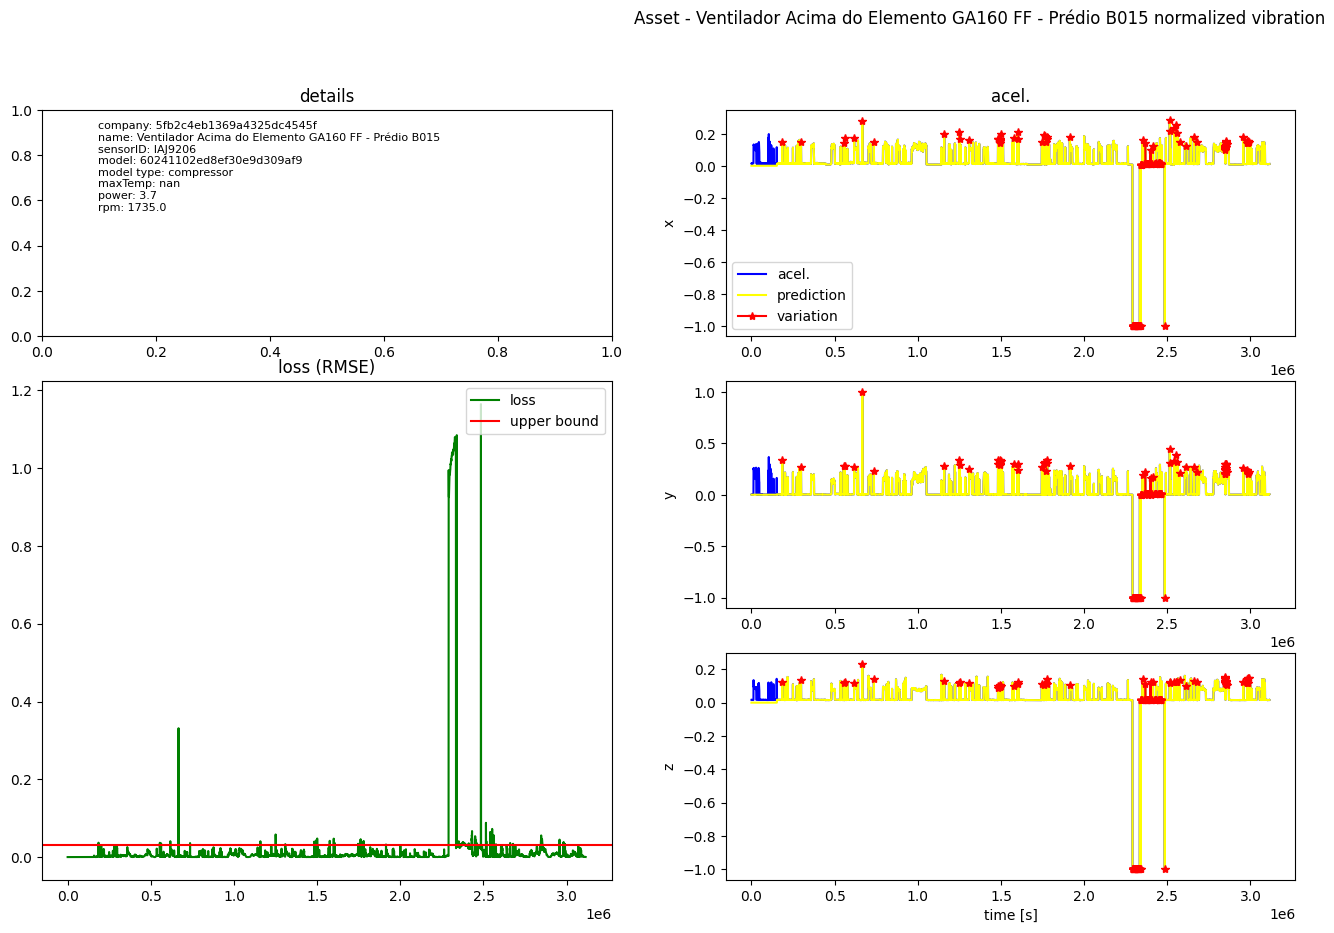

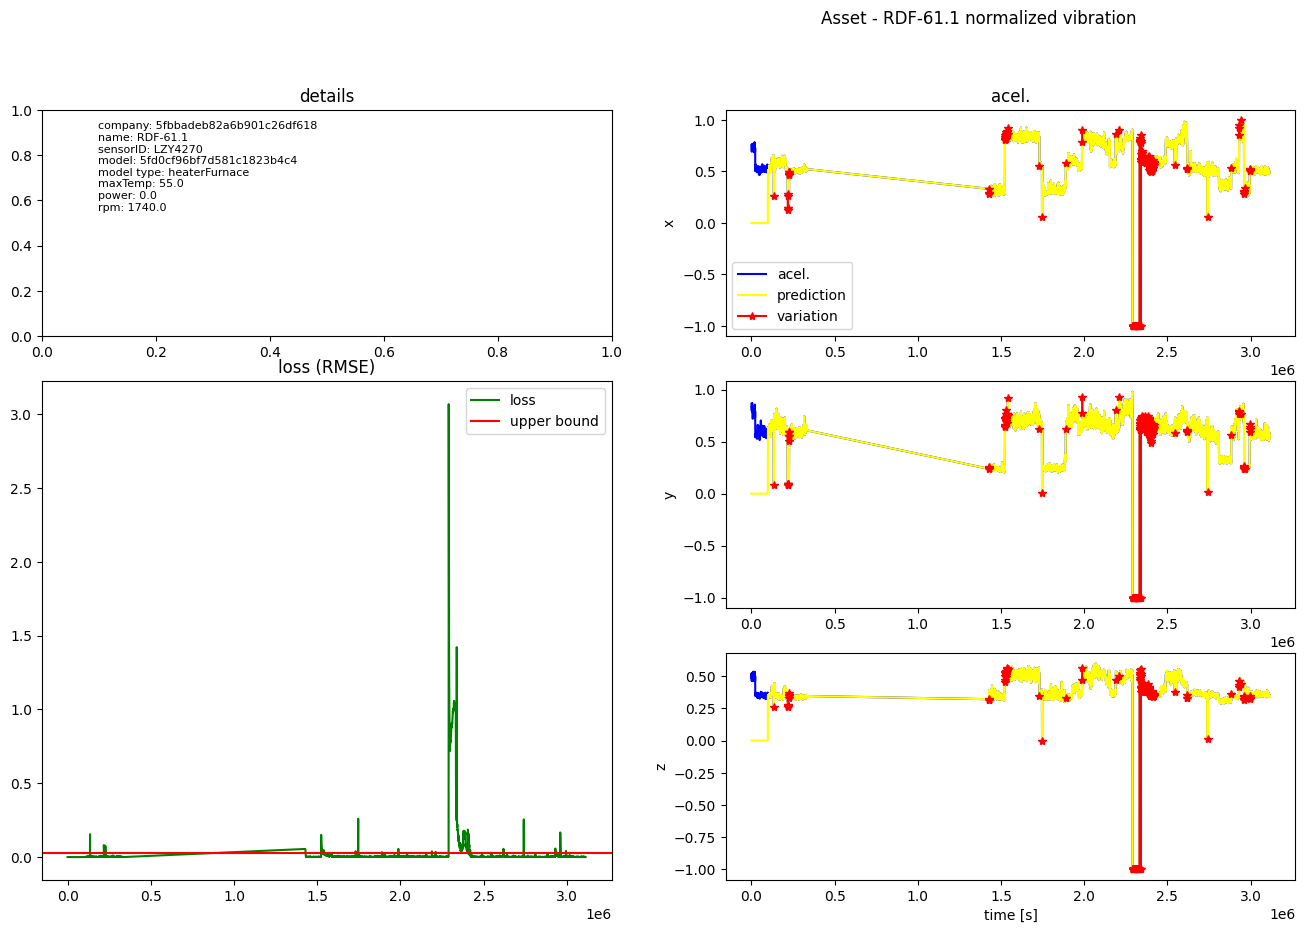

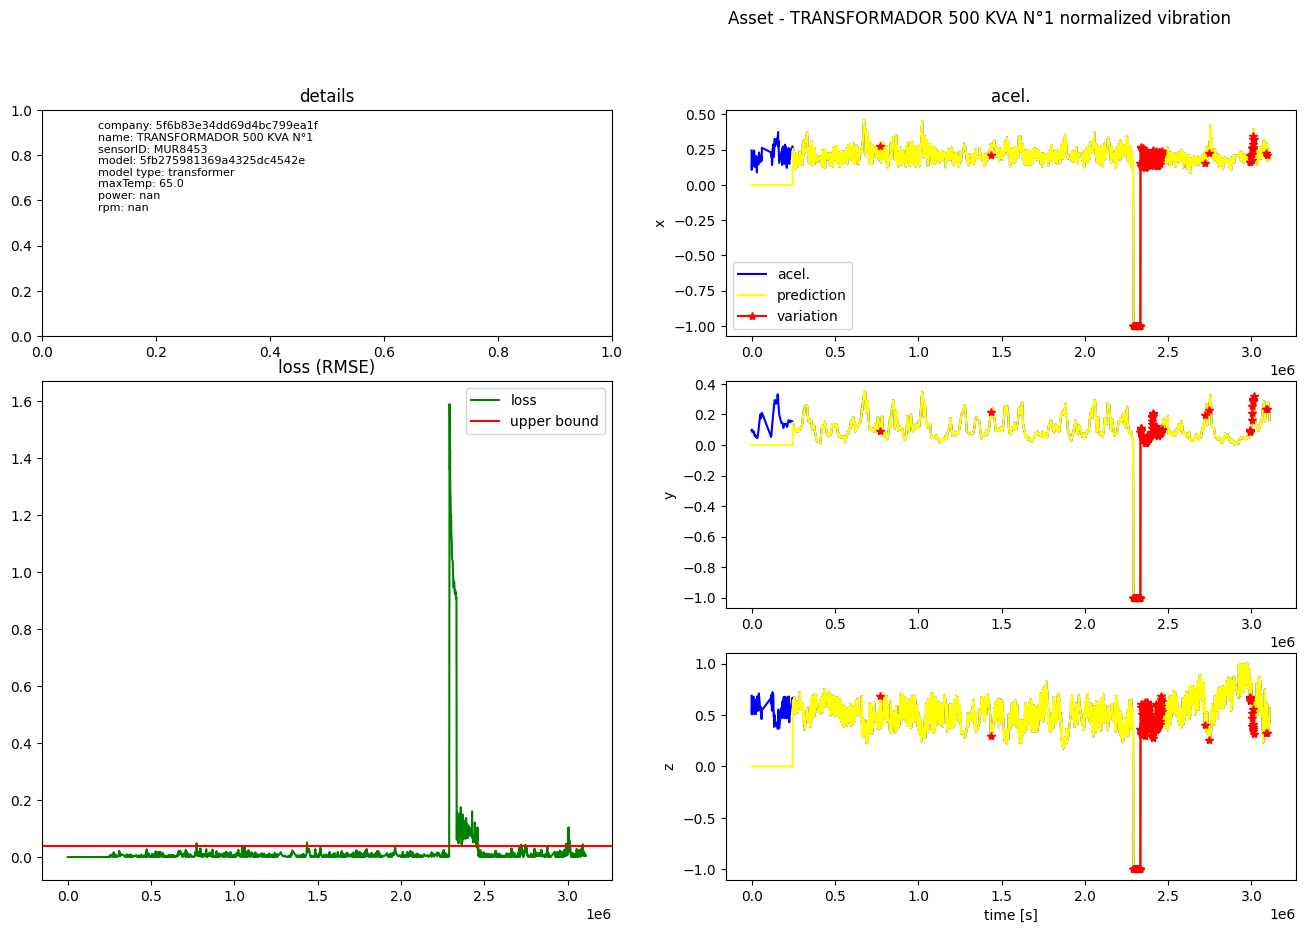

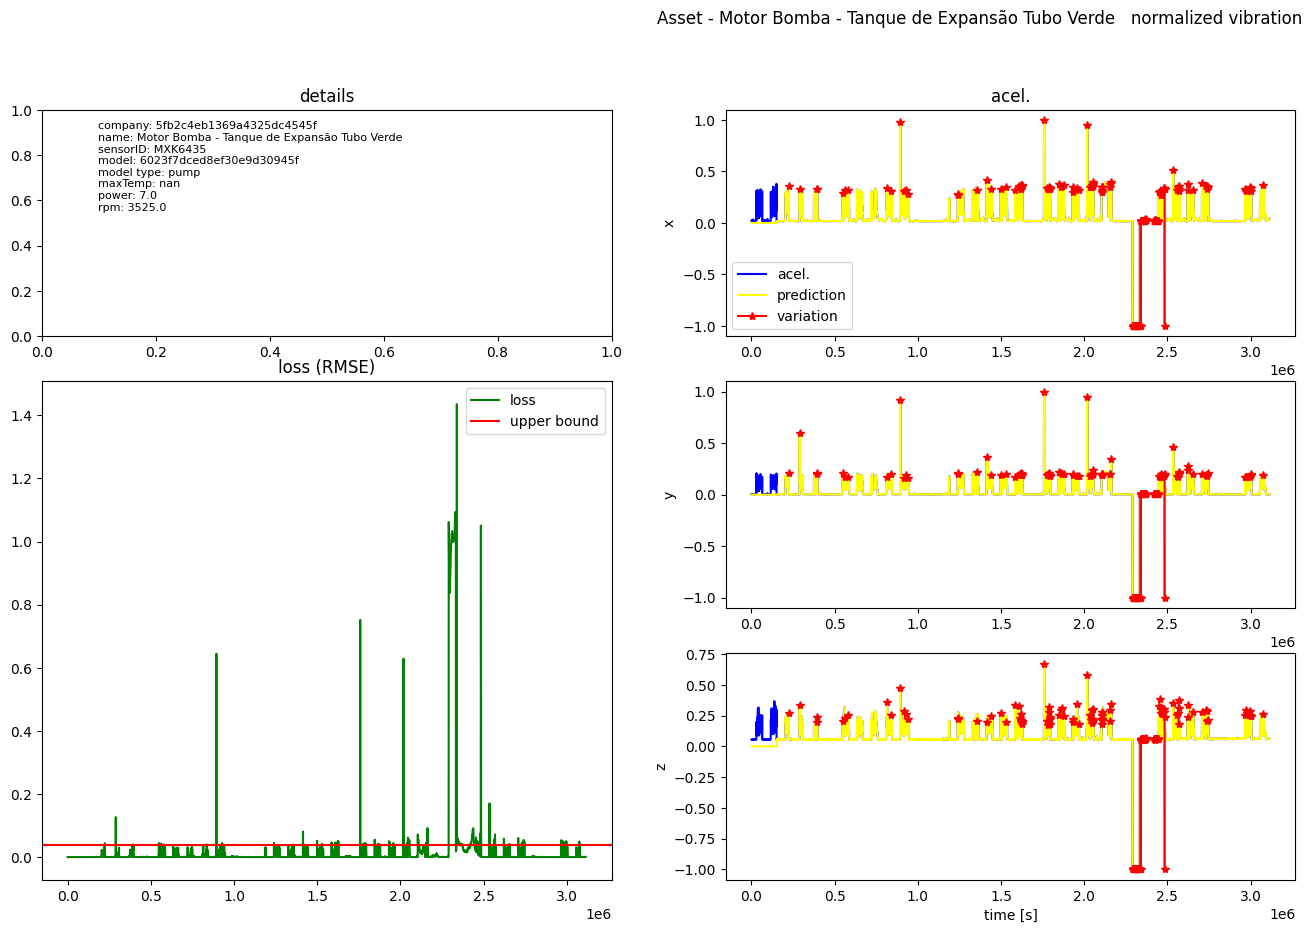

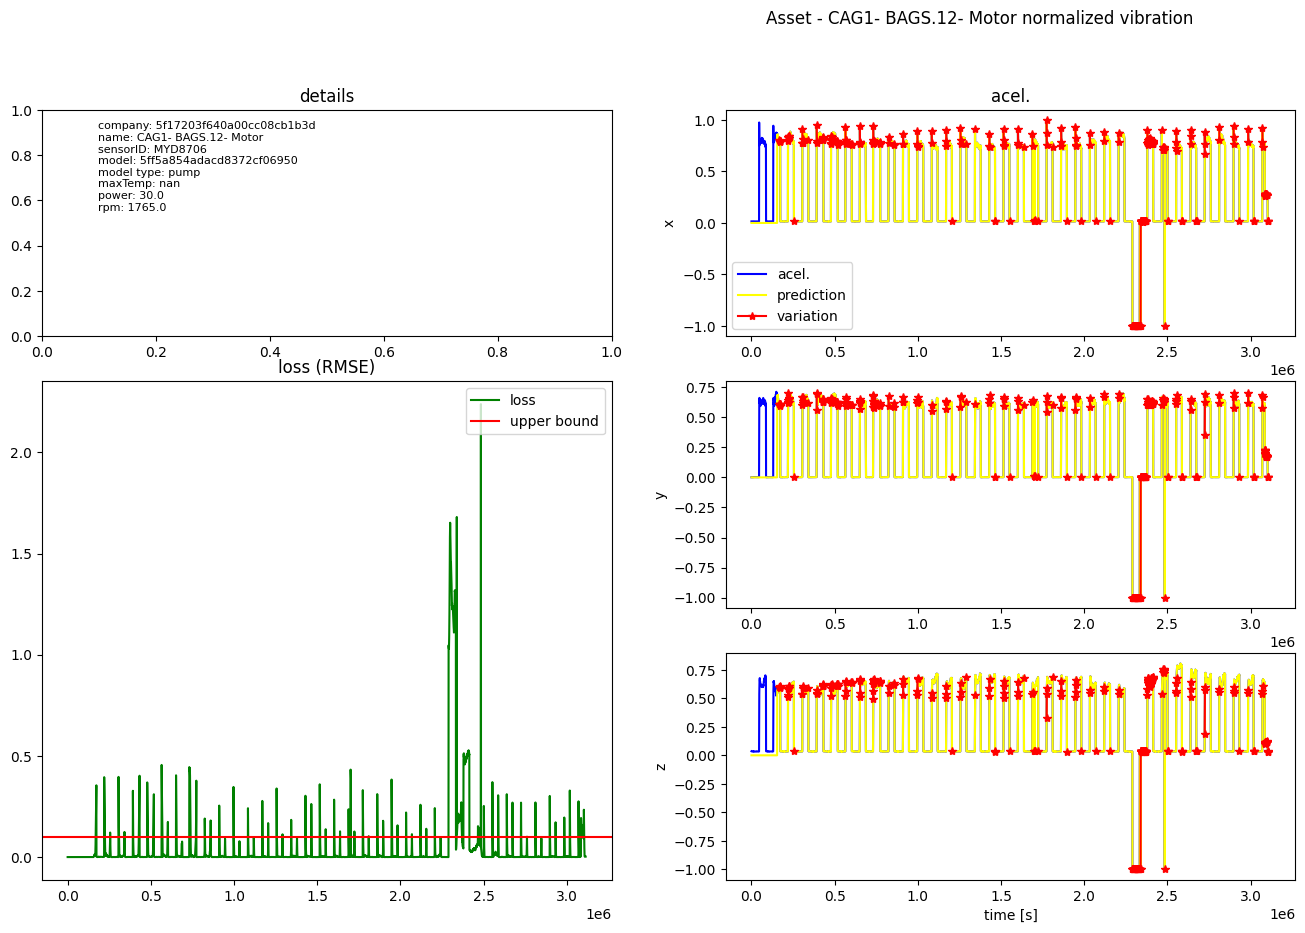

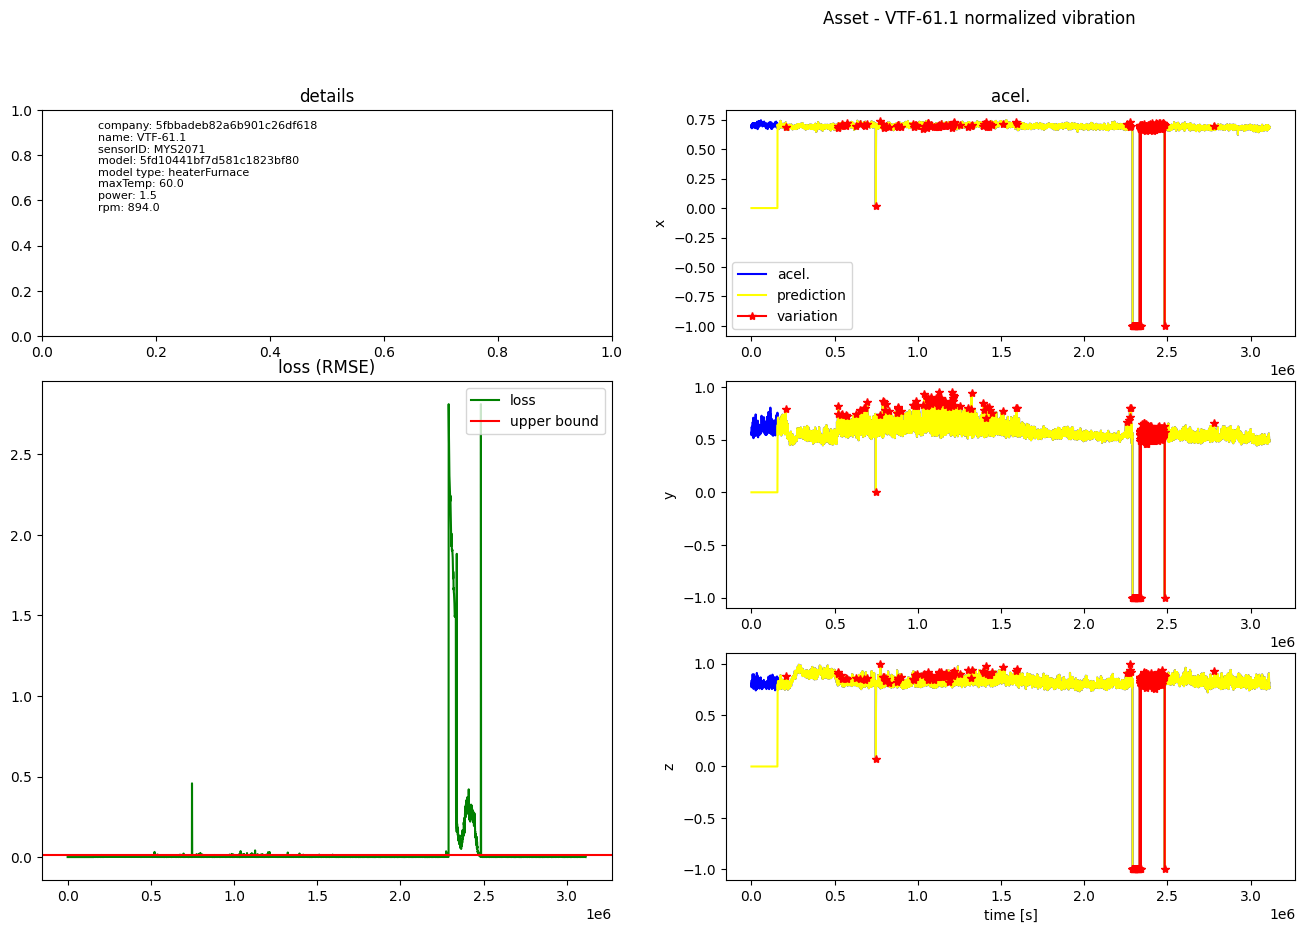

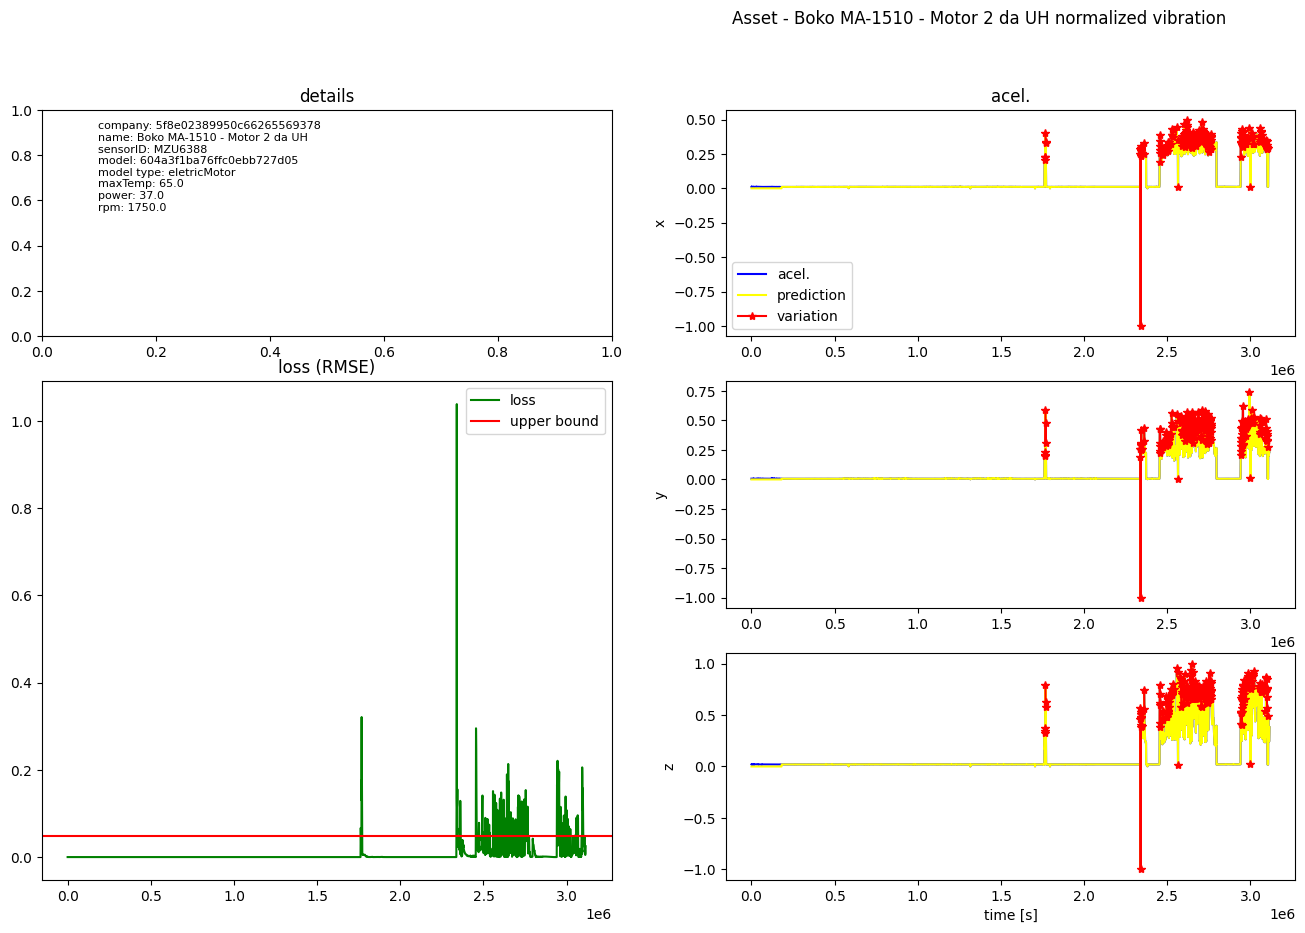

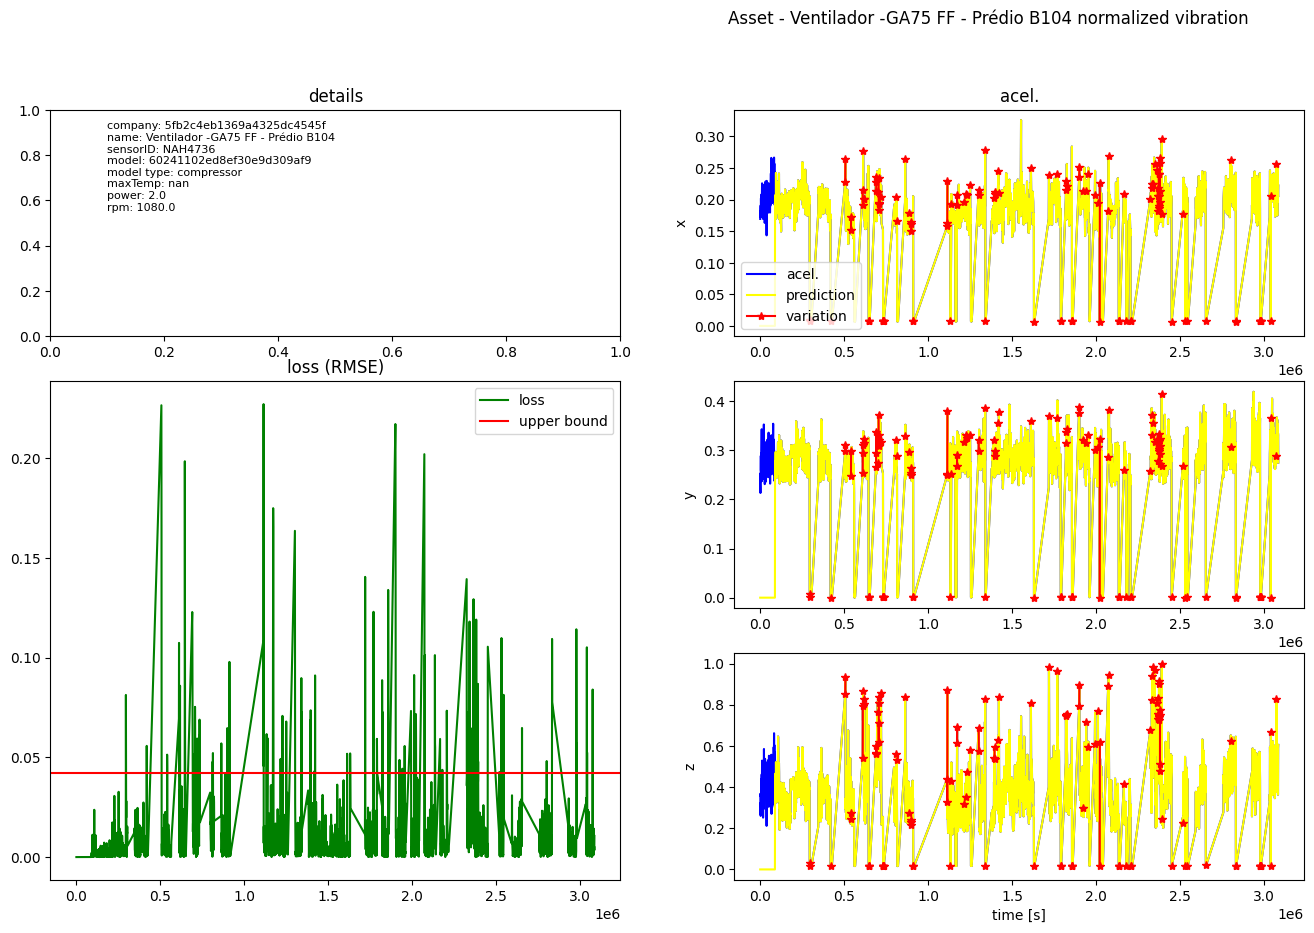

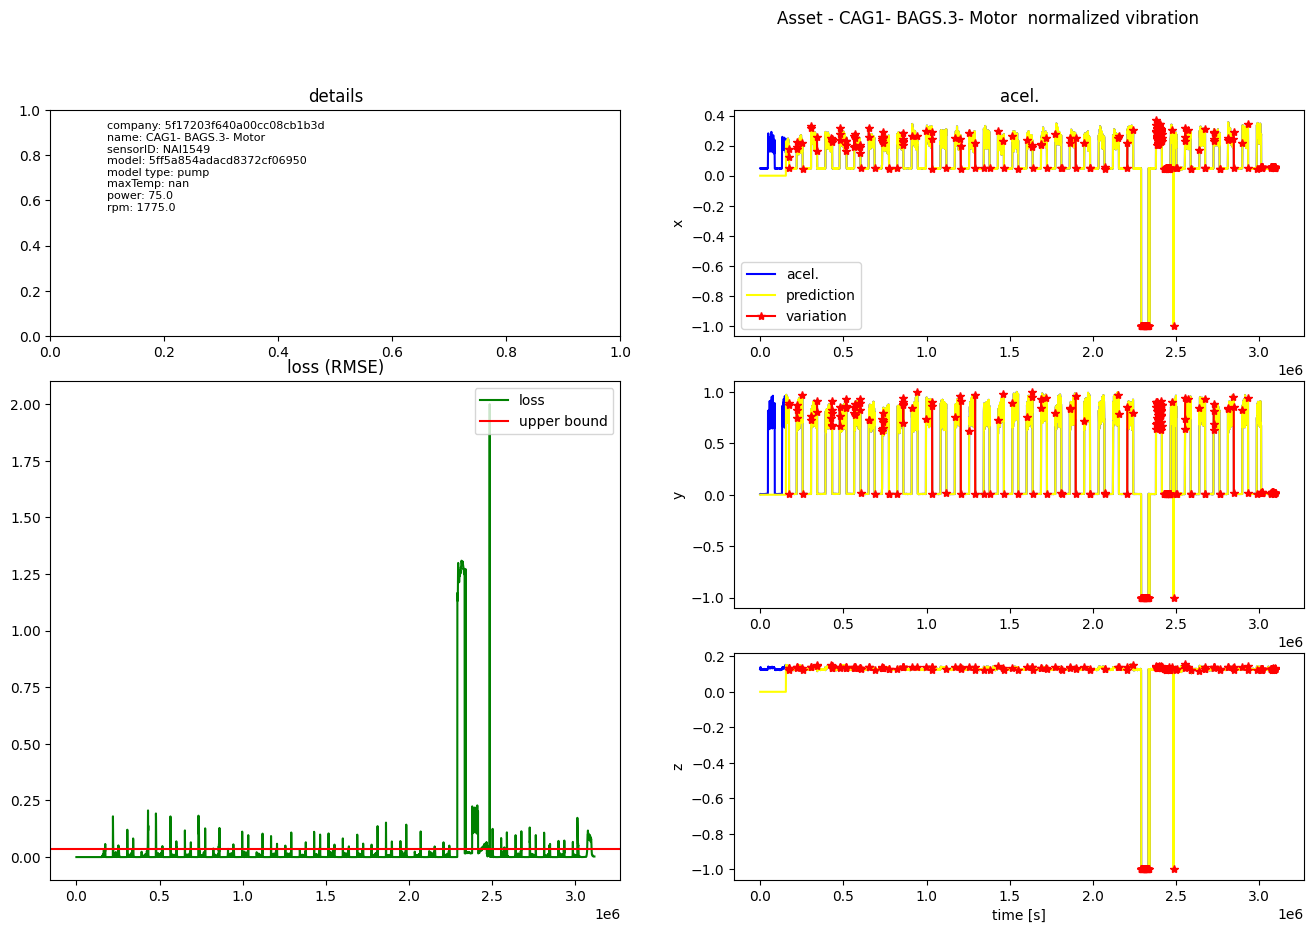

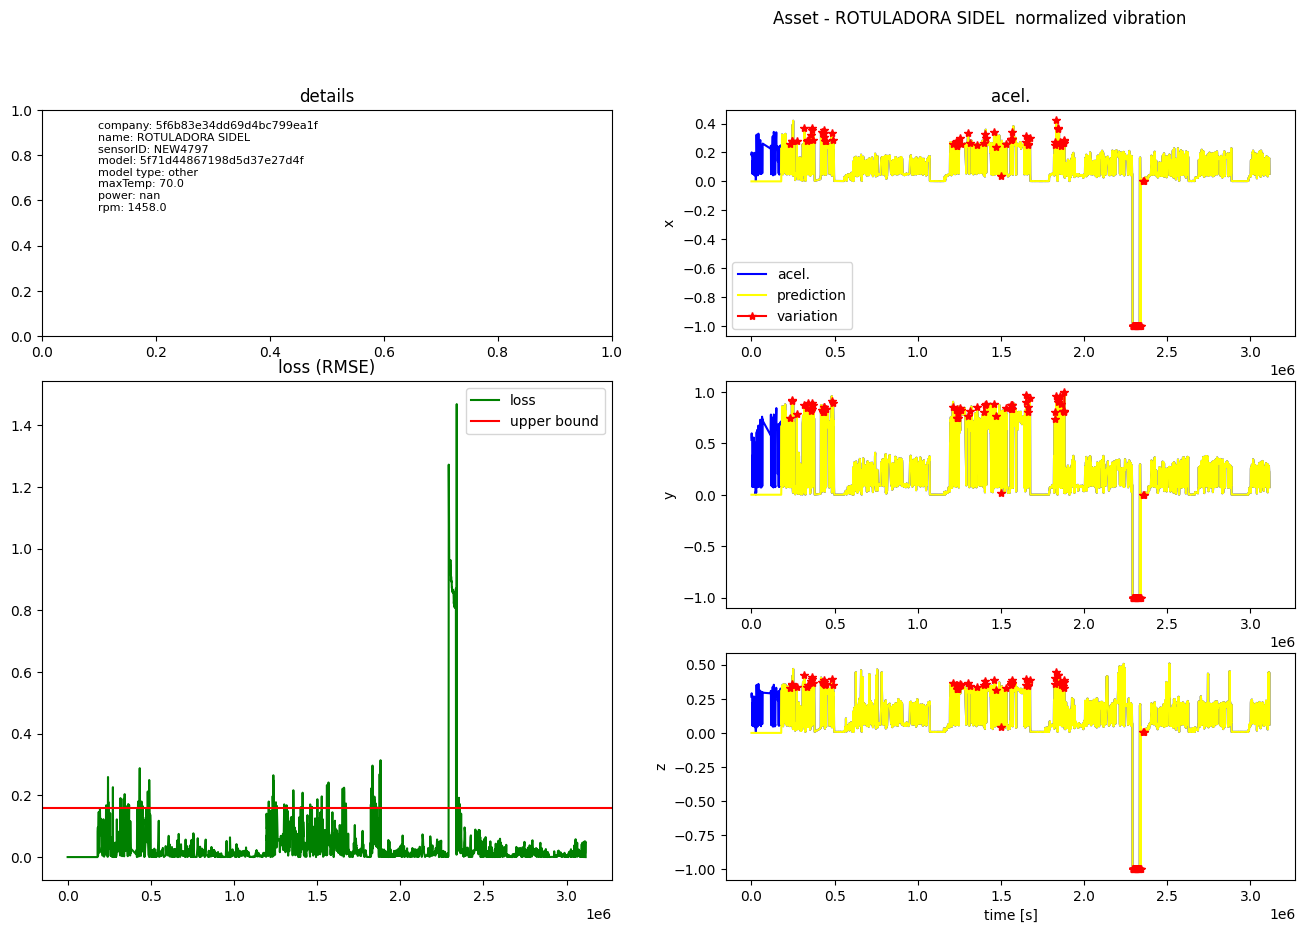

In [168]:
assetCnn = {}
for i in data:
    assetCnn[i] = Cnn(data[i])
    assetCnn[i].train(1000)
    assetCnn[i].predict()
    assetCnn[i].plotResults(data[i])

## Detecção de falhas

In [183]:
class failDetect:
    def __init__(self, df):
        self.chages_df = df[~(df['variation_x'].isnull()|df['variation_y'].isnull()|df['variation_z'].isnull())]
        self.chages_df = self.chages_df.reset_index(drop=True)
        self.chages_df['vel_abs'] = np.mod(
            self.chages_df['params.velRMS.x'],
            self.chages_df['params.velRMS.y'],
            self.chages_df['params.velRMS.z'])
        
        # normalizing velocity and temp
        self.chages_df['loss'] = (self.chages_df['loss'] -
            self.chages_df['loss'].min())/(self.chages_df['loss'].max() - self.chages_df['loss'].min())
        self.chages_df['vel_abs'] = (self.chages_df['vel_abs'] -
            self.chages_df['vel_abs'].min())/(self.chages_df['vel_abs'].max() - self.chages_df['vel_abs'].min())
        self.chages_df['vel_abs'] = self.chages_df['vel_abs'].fillna(-1)
        self.chages_df['temp'] = (self.chages_df['vel_abs'] -
            self.chages_df['temp'].min())/(self.chages_df['temp'].max() - self.chages_df['temp'].min())
        self.chages_df['temp'] = self.chages_df['temp'].fillna(-1)

        self.model_cols = ['loss','vel_abs','temp']

        self.chages_df = self.chages_df[self.model_cols + ['time_s_2']]


    def getFail(self):
        self.isForest = IsolationForest(contamination=0.05)
        pred = self.isForest.fit_predict(self.chages_df[self.model_cols])
        self.chages_df['fail'] = np.where(pred == -1, True, False)

    def plotFails(self, data):
        df = data.df.merge(self.chages_df[['time_s_2','fail']], how = 'left', on='time_s_2')
        df['fail'] = df['fail'].fillna(False)
        df['acel_x_fail'] = np.where(df['fail'], df['params.accelRMS.x'], np.nan)
        df['acel_y_fail'] = np.where(df['fail'], df['params.accelRMS.y'], np.nan)
        df['acel_z_fail'] = np.where(df['fail'], df['params.accelRMS.z'], np.nan)
        df['vel_x_fail'] = np.where(df['fail'], df['params.velRMS.x'], np.nan)
        df['vel_y_fail'] = np.where(df['fail'], df['params.velRMS.y'], np.nan)
        df['vel_z_fail'] = np.where(df['fail'], df['params.velRMS.z'], np.nan)
        df['temp_fail'] = np.where(df['fail'], df['temp'], np.nan)

        # diagram plots
        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        l1, = axes[1][0].plot(df['time_s_2'], df['params.accelRMS.x'], color='blue')
        l2, = axes[1][0].plot(df['time_s_2'], df['acel_x_fail'], 'o', color='red')
        axes[1][0].legend([l1, l2], ['acel. signal', 'fail'], loc = 'upper right')
        axes[2][0].plot(df['time_s_2'], df['params.accelRMS.y'], color='blue')
        axes[2][0].plot(df['time_s_2'], df['acel_y_fail'], 'o', color='red')
        axes[3][0].plot(df['time_s_2'], df['params.accelRMS.z'], color='blue')
        axes[3][0].plot(df['time_s_2'], df['acel_z_fail'], 'o', color='red')

        axes[1][1].plot(df['time_s_2'], df['params.velRMS.x'], color='green')
        axes[1][1].plot(df['time_s_2'], df['vel_x_fail'], 'o', color='red')
        axes[2][1].plot(df['time_s_2'], df['params.velRMS.y'], color='green')
        axes[2][1].plot(df['time_s_2'], df['vel_y_fail'], 'o', color='red')
        axes[3][1].plot(df['time_s_2'], df['params.velRMS.z'], color='green')
        axes[3][1].plot(df['time_s_2'], df['vel_z_fail'], 'o', color='red')

        axes[0][1].plot(df['time_s_2'], df['temp'], color = 'orange')
        axes[0][1].plot(df['time_s_2'], df['temp_fail'], 'o', color = 'red')

        axes[0][0].text(0.05, 0.95, data.details, fontsize=8, horizontalalignment='left', verticalalignment='top')

        fig.suptitle('Asset - {}'.format(data.name))
        axes[0,0].set_title('details')
        axes[0,1].set_title('temp.')
        axes[1,0].set_title('acel.')
        axes[1,1].set_title('veloc.')
        axes[1,0].set_ylabel('x')
        axes[2,0].set_ylabel('y')
        axes[3,0].set_ylabel('z')
        axes[3,0].set_xlabel('time')
        axes[3,1].set_xlabel('time')

        
        pass
        

C:\Users\mat_f\AppData\Local\Temp\ipykernel_23656\1772059753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.chages_df['vel_abs'] = np.mod(
C:\Users\mat_f\AppData\Local\Temp\ipykernel_23656\1772059753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.chages_df['vel_abs'] = np.mod(
C:\Users\mat_f\AppData\Local\Temp\ipykernel_23656\1772059753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.chages_df['vel_abs'] = 

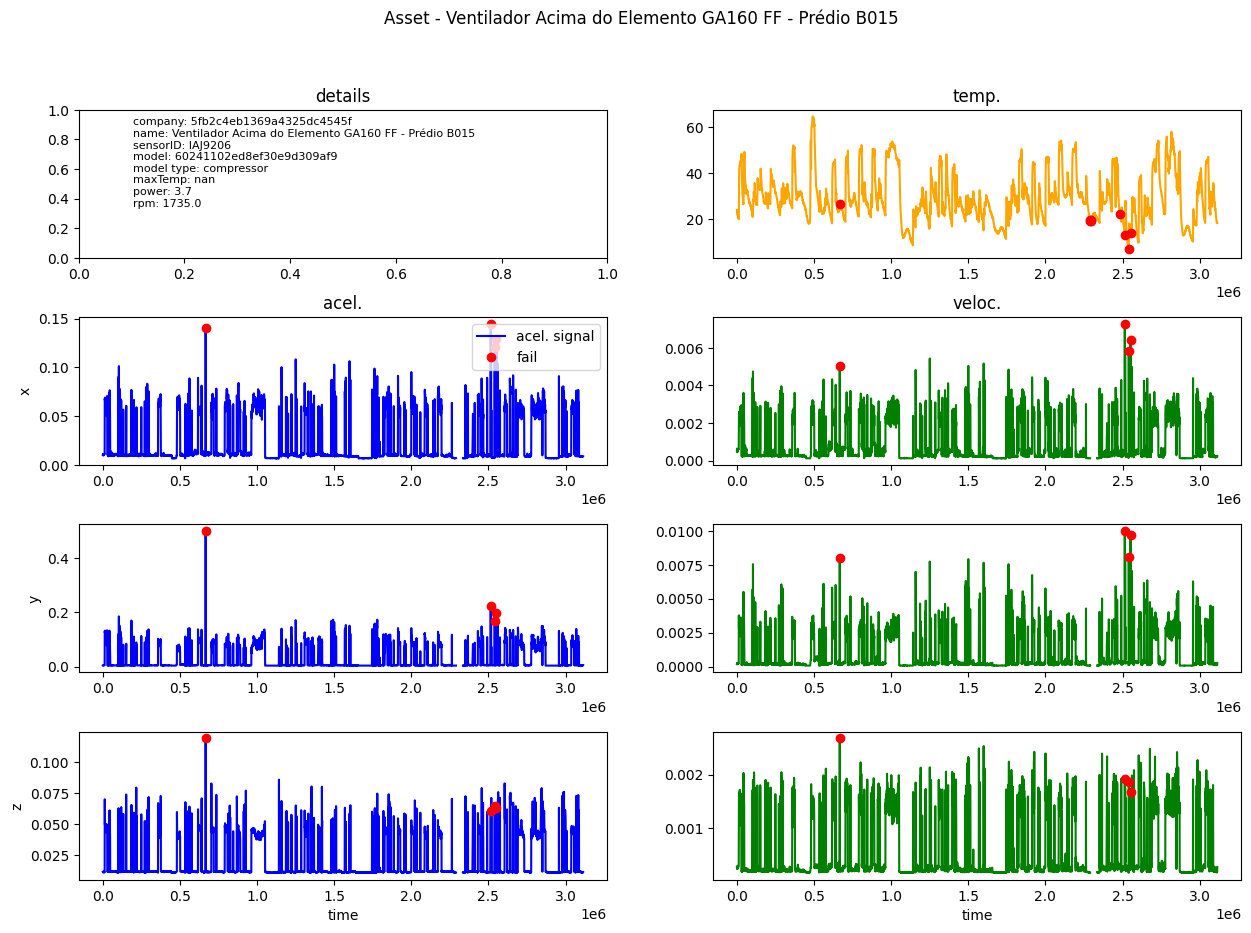

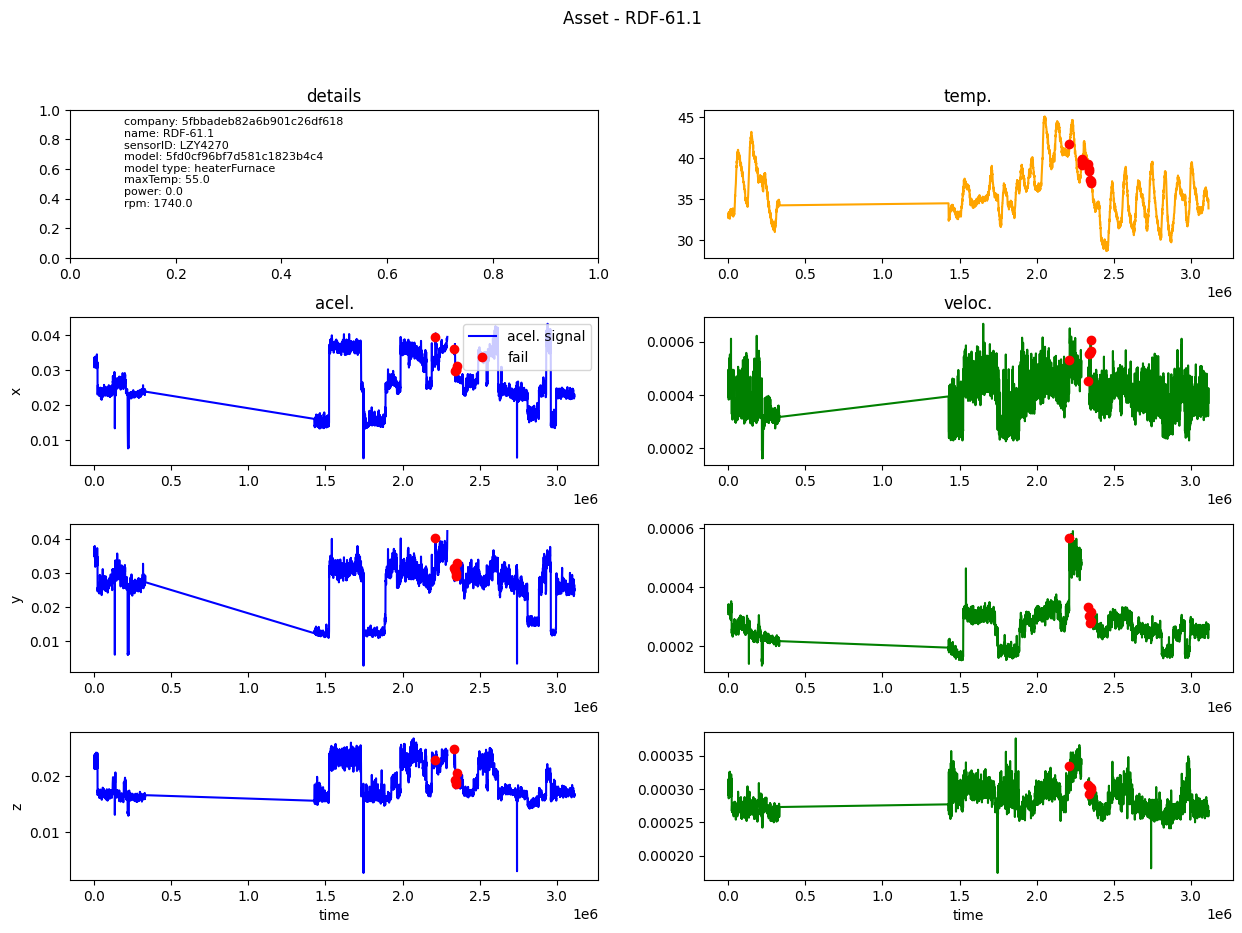

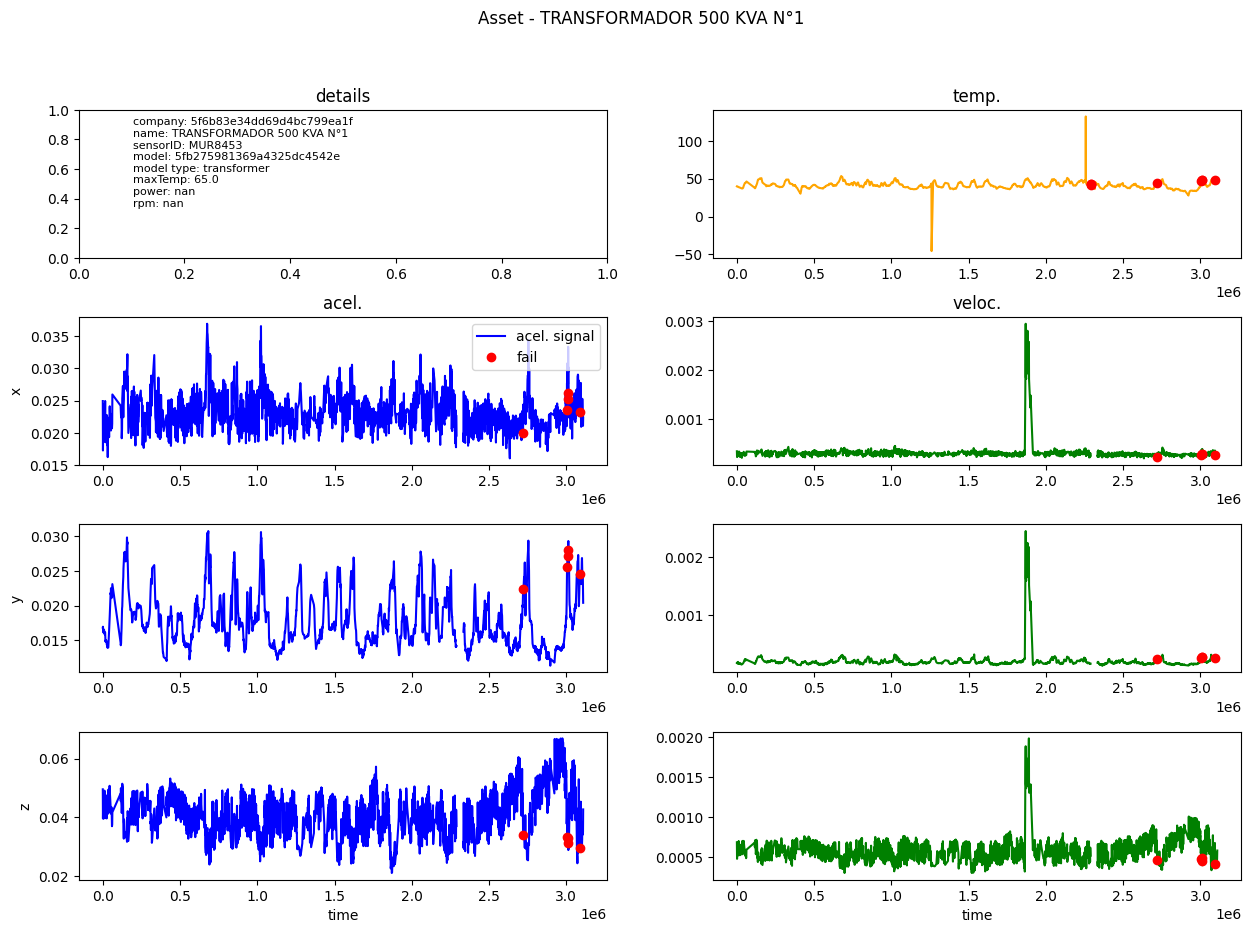

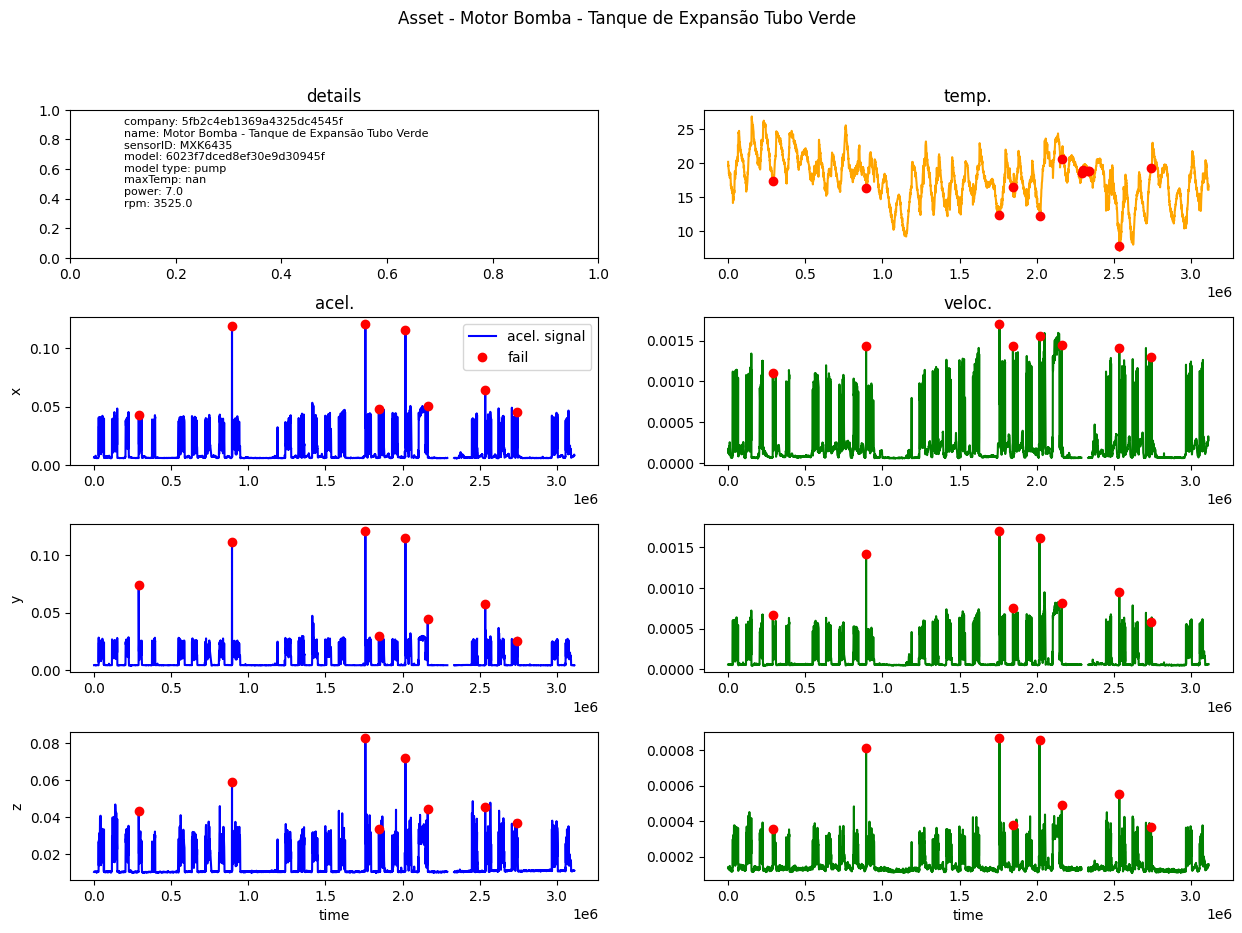

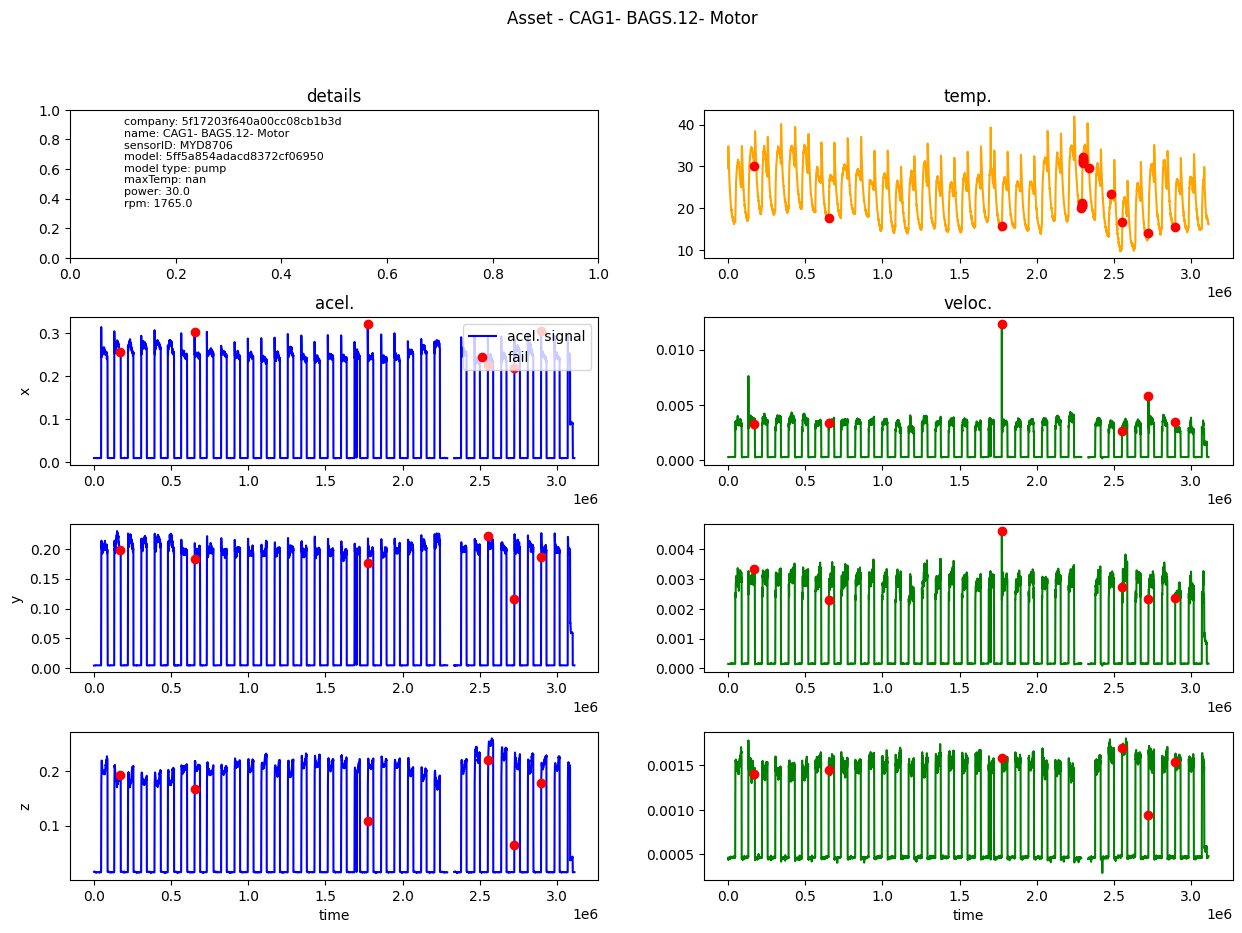

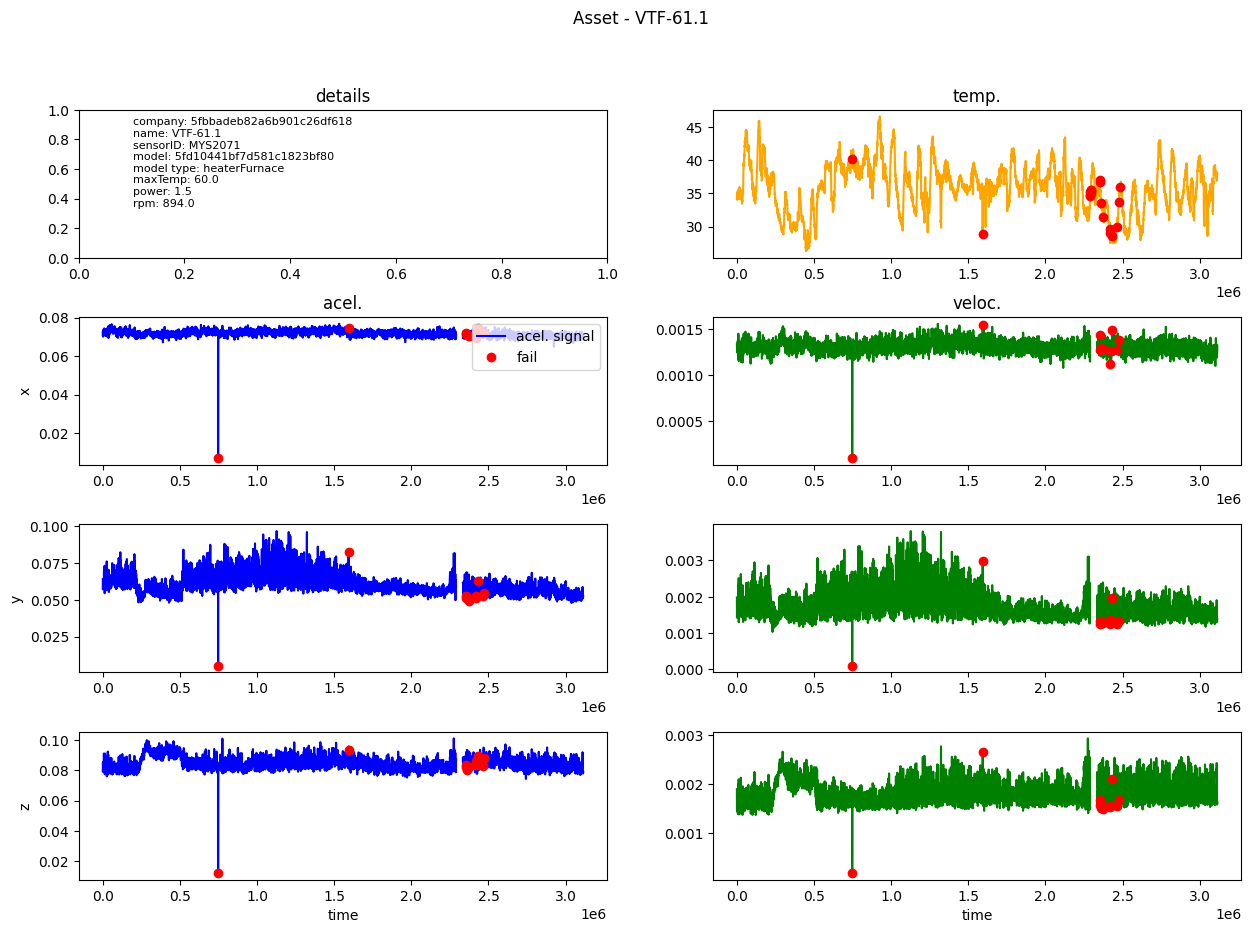

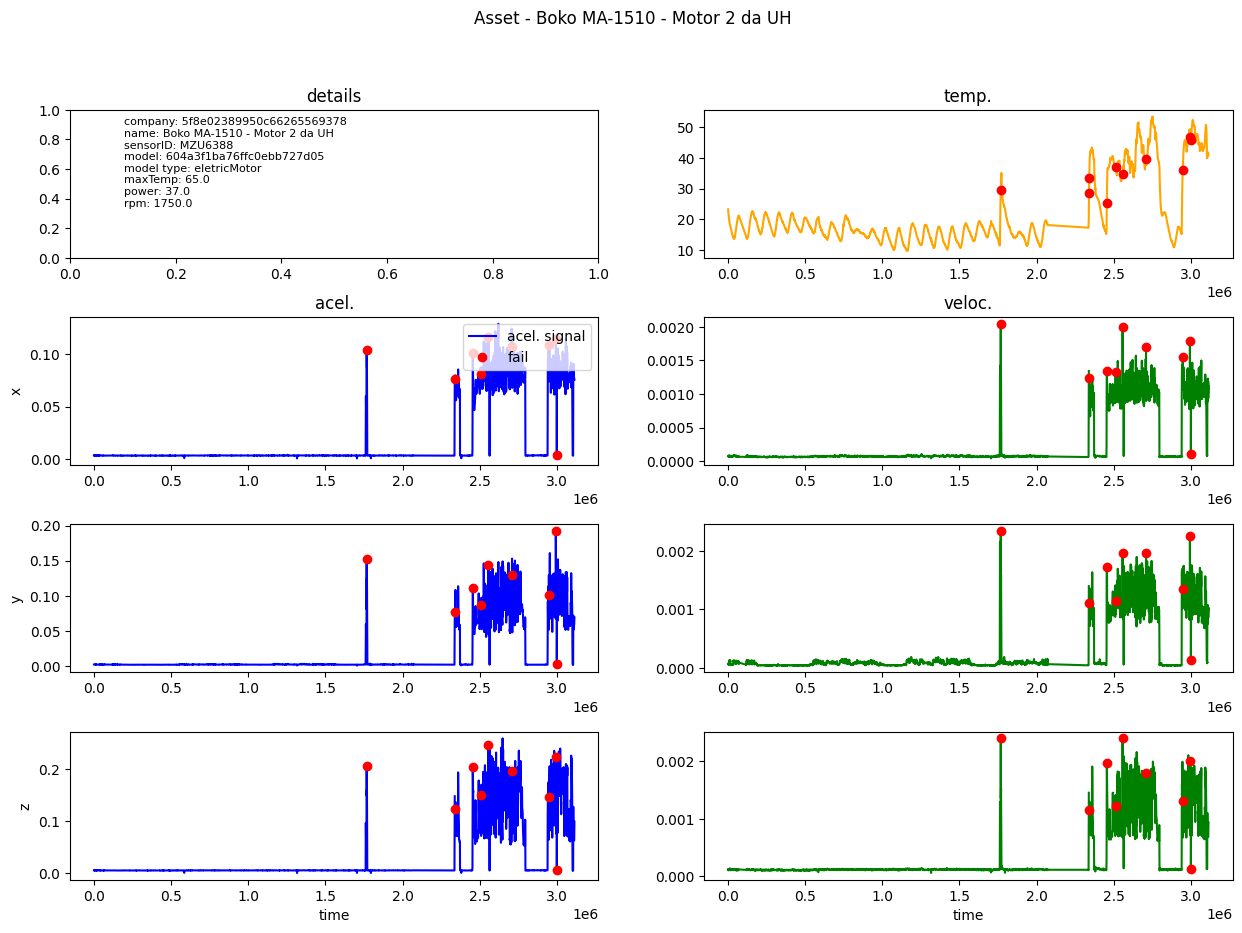

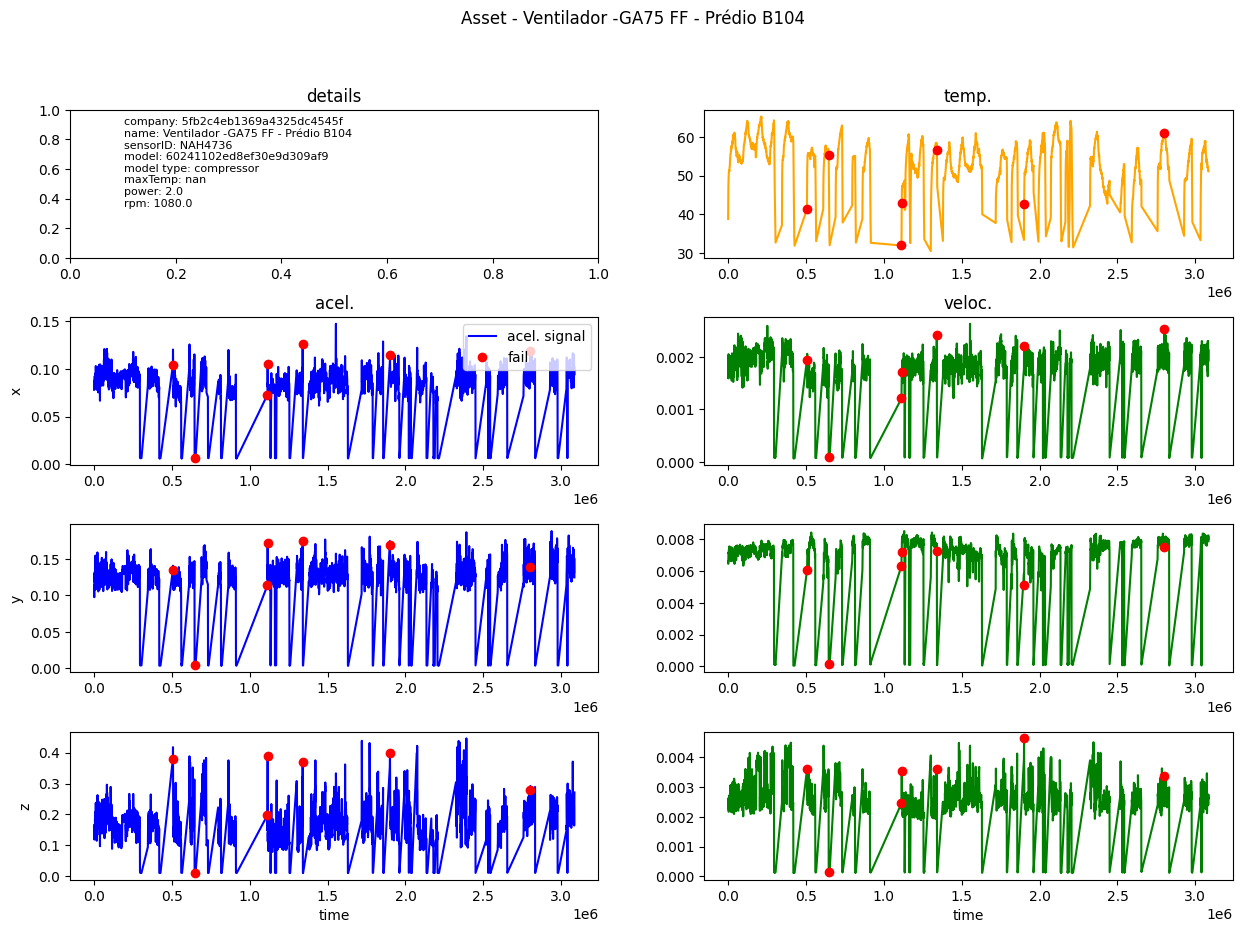

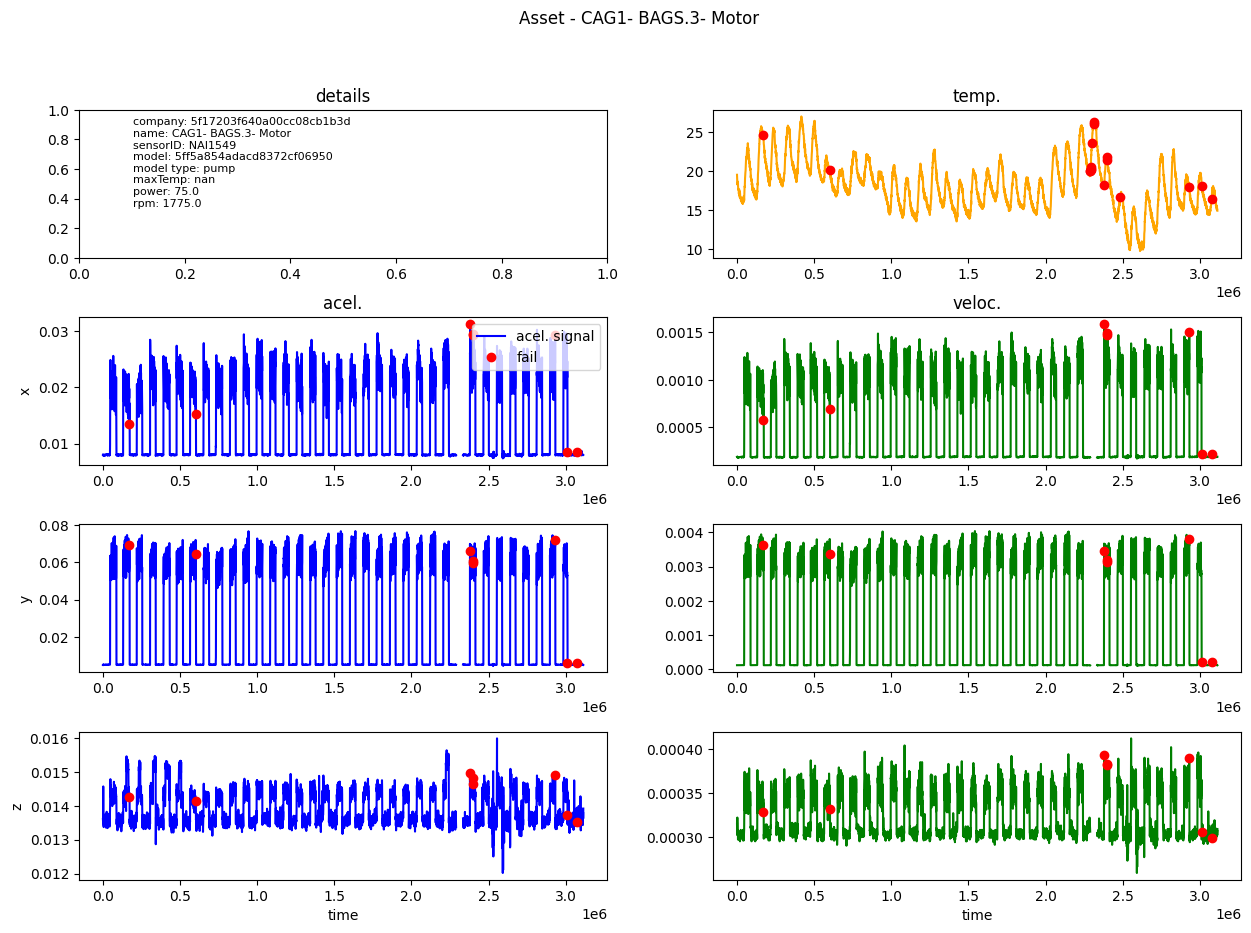

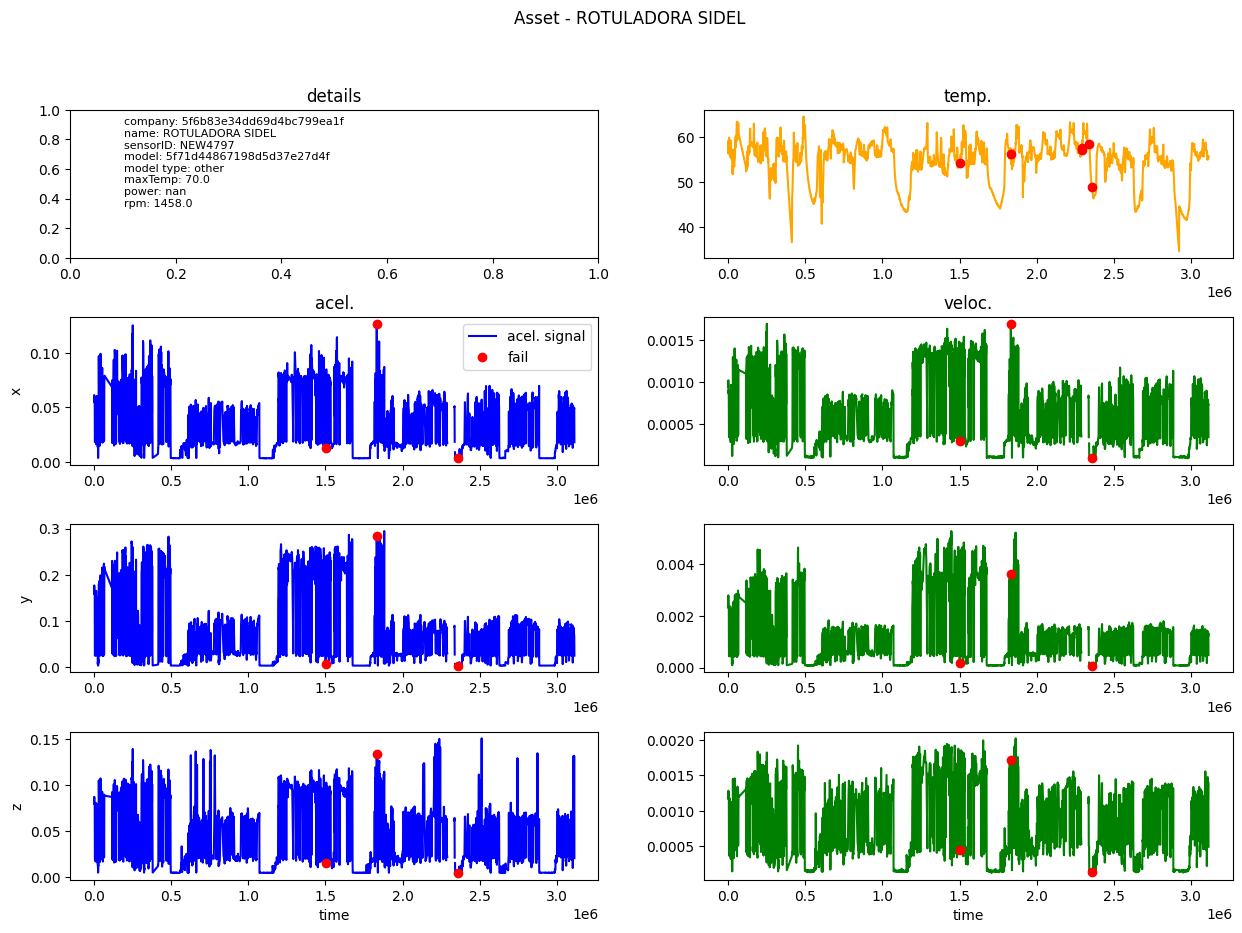

In [184]:
fail = {}
for i in data:
    fail[i] = failDetect(assetCnn[i].pred_df)
    fail[i].getFail()
    fail[i].plotFails(data[i])

In [171]:
assetCnn[i].pred_df.columns

Index(['_id_x', 'created', 'params.accelRMS.x', 'params.accelRMS.y',
       'params.accelRMS.z', 'params.duration', 'params.sampRate',
       'params.timeStart', 'params.velRMS.x', 'params.velRMS.y',
       'params.velRMS.z', 'sensorId', 'temp', '_id_y', 'company', 'createdAt',
       'description', 'model', 'modelType', 'name', 'specifications.axisX',
       'specifications.axisY', 'specifications.axisZ',
       'specifications.maxDowntime', 'specifications.maxTemp',
       'specifications.power', 'specifications.rpm', 'specifications.workdays',
       'delta_created', 'time_s', 'time_s_2', 'time_s_3', 'downtime',
       'params.accelRMS.x_n_x', 'params.accelRMS.y_n_x',
       'params.accelRMS.z_n_x', 'params.accelRMS.x_n_y',
       'params.accelRMS.y_n_y', 'params.accelRMS.z_n_y', 'loss', 'pred_x',
       'pred_y', 'pred_z', 'variation_x', 'variation_y', 'variation_z'],
      dtype='object')

In [172]:
assetCnn

{'IAJ9206': <__main__.Cnn at 0x1e863736e50>,
 'LZY4270': <__main__.Cnn at 0x1e859beb650>,
 'MUR8453': <__main__.Cnn at 0x1e85f621190>,
 'MXK6435': <__main__.Cnn at 0x1e8092a5710>,
 'MYD8706': <__main__.Cnn at 0x1e8025c4090>,
 'MYS2071': <__main__.Cnn at 0x1e804482650>,
 'MZU6388': <__main__.Cnn at 0x1e8093c5150>,
 'NAH4736': <__main__.Cnn at 0x1e8098579d0>,
 'NAI1549': <__main__.Cnn at 0x1e80a47e2d0>,
 'NEW4797': <__main__.Cnn at 0x1e80a5dd650>}

In [173]:
data['IAJ9206'].df

_id_x                 created  params.accelRMS.x  \
0     60b57955f77013684c413e39 2021-06-01 00:03:33.370           0.010463   
1     60b57c53f77013684c41409f 2021-06-01 00:16:19.173           0.011437   
2     60b57f34f77013684c4142cd 2021-06-01 00:28:36.553           0.010494   
3     60b58237f77013684c41450c 2021-06-01 00:41:27.622           0.009859   
4     60b58515f77013684c414765 2021-06-01 00:53:41.450           0.010014   
...                        ...                     ...                ...   
3981  60e4f26935645405b62ea5fb 2021-07-07 00:16:41.693           0.008619   
3982  60e4f56335645405b62ea82a 2021-07-07 00:29:23.955           0.008664   
3983  60e4f86535645405b62eaa44 2021-07-07 00:42:13.371           0.008754   
3984  60e4fb5735645405b62eac5c 2021-07-07 00:54:47.091           0.008704   
3985  60e4fe3135645405b62eae57 2021-07-07 01:06:57.975           0.008957   

      params.accelRMS.y  params.accelRMS.z  params.duration  params.sampRate  \
0              0.004463           0.011677            3.006      1656.686627   
1              0.004983           0.011482            3.006      1656.686627   
2              0.005024           0.011120            3.006      1656.686627   
3              0.004786           0.011096            3.006      1656.686627   
4              0.005213           0.011332            3.006      1656.686627   
...                 ...                ...              ...              ...   
3981           0.004223           0.011166            3.006      1656.686627   
3982           0.004379           0.011025            3.006      1656.686627   
3983           0.004327           0.011052            3.006      1656.686627   
3984           0.004497           0.011002            3.006      1656.686627   
3985           0.005472           0.011353            3.006      1656.686627   

      params.timeStart  params.velRMS.x  params.velRMS.y  ...  \
0         1.622506e+09         0.000511         0.000176  ...   
1         1.622507e+09         0.000633         0.000238  ...   
2         1.622507e+09         0.000524         0.000226  ...   
3         1.622508e+09         0.000437         0.000220  ...   
4         1.622509e+09         0.000501         0.000251  ...   
...                ...              ...              ...  ...   
3981      1.625617e+09         0.000179         0.000110  ...   
3982      1.625618e+09         0.000184         0.000124  ...   
3983      1.625619e+09         0.000183         0.000106  ...   
3984      1.625619e+09         0.000190         0.000144  ...   
3985      1.625620e+09         0.000227         0.000266  ...   

      specifications.rpm specifications.workdays  delta_created       time_s  \
0                 1735.0                     NaN        765.803        0.000   
1                 1735.0                     NaN        737.380      765.803   
2                 1735.0                     NaN        771.069     1503.183   
3                 1735.0                     NaN        733.828     2274.252   
4                 1735.0                     NaN        732.857     3008.080   
...                  ...                     ...            ...          ...   
3981              1735.0                     NaN        762.262  3111188.323   
3982              1735.0                     NaN        769.416  3111950.585   
3983              1735.0                     NaN        753.720  3112720.001   
3984              1735.0                     NaN        730.884  3113473.721   
3985              1735.0                     NaN            NaN  3114204.605   

       time_s_2   time_s_3 downtime params.accelRMS.x_n params.accelRMS.y_n  \
0           0.0        0.0     True            0.014234            0.002111   
1         766.0      766.0     True            0.016202            0.003162   
2        1503.0     1503.0     True            0.014297            0.003245   
3        2275.0     2275.0     True            0.013014            0.002764   
4 